In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!nvidia-smi

Tue Jan 14 15:41:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


In [ ]:
!pip install ultralytics==8.2.103 -q

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6037.7/8062.4 GB disk)


In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

/kaggle/working
100%|██████████████████████████████████████| 6.25M/6.25M [00:00<00:00, 84.7MB/s]
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

100%|████████████████████████████████████████| 104k/104k [00:00<00:00, 72.6MB/s]
image 1/1 /kaggle/working/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 51.8ms
Speed: 8.6ms preprocess, 51.8ms inference, 257.7ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


/kaggle/working


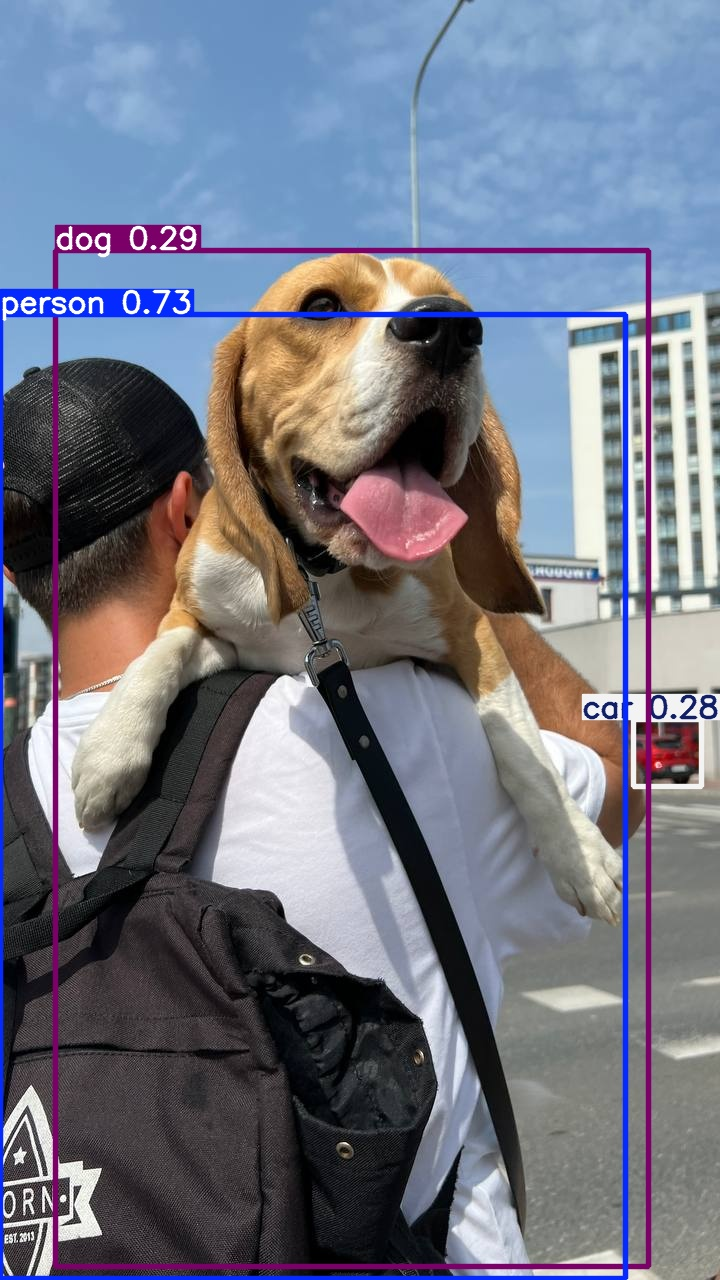

In [ ]:
%cd {HOME}
Image(filename='runs/detect/predict/dog.jpeg', height=600)

In [ ]:
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0XuHi2VgGqme2HRZpjjp")
project = rf.workspace("handrecognizer").project("student-action-recognition")
version = project.version(1)
dataset = version.download("yolov8")

/kaggle/working/datasets
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Student-action-recognition-1 in yolov8:: 100%|██████████| 10868/10868 [00:01<00:00, 7999.53it/s]


In [ ]:
!pip install ultralytics transformers torchvision roboflow opencv-python matplotlib -q


In [ ]:
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from roboflow import Roboflow


In [ ]:
# Load the YOLOv8 model
yolo_model = YOLO("yolov8n.pt")  # Change to 'best.pt' after training

100%|██████████| 6.25M/6.25M [00:00<00:00, 83.5MB/s]


In [ ]:
# Initialize Roboflow
rf = Roboflow(api_key="0XuHi2VgGqme2HRZpjjp")
project = rf.workspace("handrecognizer").project("student-action-recognition")
version = project.version(1)
dataset = version.download("yolov8")  # Download YOLO-formatted dataset

# Define dataset path
DATASET_PATH = dataset.location
print("Dataset downloaded at:", DATASET_PATH)


loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded at: /kaggle/working/datasets/Student-action-recognition-1


In [ ]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def _init_(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super()._init_()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def _init_(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super()._init_()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def _init_(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super()._init_()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def _init_(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super()._init_()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def _init_(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super()._init_()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def _init_(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super()._init_()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}{W}) doesn't match model ({self.img_size[0]}{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinTransformer(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : ⁠ Swin Transformer: Hierarchical Vision Transformer using Shifted Windows

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def _init_(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super()._init_()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

In [ ]:
import os
import torch
from ultralytics import YOLO
from roboflow import Roboflow
from IPython.display import Image, display


In [ ]:
%cd {HOME}
model = YOLO('yolov8n.pt')
vit_model = create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=0)
for param in vit_model.parameters():
    param.requires_grad = False
model.model.model[-2] = vit_model


/kaggle/working


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [ ]:
%cd {HOME}
model.train(data=f'{dataset.location}/data.yaml', epochs=50, imgsz=800, plots=True)


/kaggle/working
New https://pypi.org/project/ultralytics/8.3.61 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/datasets/Student-action-recognition-1/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=No

train: Scanning /kaggle/working/datasets/Student-action-recognition-1/train/labels.cache... 4749 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4749/4749 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/datasets/Student-action-recognition-1/valid/labels.cache... 453 images, 0 backgrounds, 0 corrupt: 100%|██████████| 453/453 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.32G     0.2239     0.1528      1.101         13        800: 100%|██████████| 297/297 [01:13<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.54it/s]

                   all        453        453      0.997      0.994      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.26G     0.2468     0.2384      1.133         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.44it/s]

                   all        453        453       0.99      0.992      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.26G     0.2601     0.2643      1.154         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.61it/s]

                   all        453        453      0.986      0.996      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.26G     0.2637     0.2665       1.16         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.17it/s]

                   all        453        453       0.94      0.966      0.994      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.25G     0.2629     0.2556      1.156         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.37it/s]

                   all        453        453      0.989      0.991      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.25G     0.2595     0.2256      1.154         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.49it/s]

                   all        453        453      0.967      0.968      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.25G     0.2608     0.2304      1.148         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.27it/s]

                   all        453        453      0.982      0.976      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.26G      0.255     0.2079      1.144         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.47it/s]

                   all        453        453      0.998      0.999      0.995      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.25G     0.2505     0.2056      1.141         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.45it/s]

                   all        453        453      0.992      0.994      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.25G     0.2527     0.1967      1.139         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.31it/s]

                   all        453        453      0.995      0.977      0.994       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.25G     0.2565     0.1988      1.139         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.51it/s]

                   all        453        453      0.979      0.988      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.26G     0.2441     0.1893      1.129         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.48it/s]

                   all        453        453      0.987      0.995      0.995       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.25G     0.2451     0.1841      1.126         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]

                   all        453        453      0.997      0.998      0.995      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.25G     0.2419     0.1775      1.128         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.40it/s]

                   all        453        453      0.999      0.999      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.25G     0.2383     0.1783      1.118         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]

                   all        453        453      0.987      0.993      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.26G     0.2371     0.1694      1.115         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.48it/s]

                   all        453        453      0.999          1      0.995      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.25G     0.2391     0.1705      1.121         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.58it/s]

                   all        453        453      0.997      0.998      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.25G     0.2371     0.1695      1.115         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.45it/s]

                   all        453        453      0.999          1      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.25G     0.2331     0.1623      1.109         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.53it/s]

                   all        453        453      0.999      0.999      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.26G     0.2325     0.1663       1.11         13        800: 100%|██████████| 297/297 [01:12<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.50it/s]

                   all        453        453      0.999      0.997      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.25G     0.2304     0.1593      1.107         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.31it/s]

                   all        453        453      0.992      0.994      0.992       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.25G       0.23     0.1571      1.107         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]

                   all        453        453      0.999          1      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.25G     0.2285     0.1534      1.106         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.33it/s]

                   all        453        453      0.999          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.26G     0.2253     0.1534      1.101         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.56it/s]

                   all        453        453      0.997      0.996      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.25G     0.2206     0.1446      1.092         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.47it/s]

                   all        453        453      0.999          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.25G     0.2233     0.1532      1.095         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.06it/s]

                   all        453        453      0.996      0.999      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.25G     0.2261     0.1419      1.096         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.44it/s]

                   all        453        453      0.999      0.999      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.26G     0.2178     0.1409      1.085         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.41it/s]

                   all        453        453      0.998          1      0.995      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.25G      0.215      0.138      1.082         13        800: 100%|██████████| 297/297 [01:09<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.63it/s]

                   all        453        453      0.998      0.998      0.995      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.25G     0.2158      0.138      1.084         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.50it/s]

                   all        453        453      0.999          1      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.25G     0.2141     0.1335      1.084         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.55it/s]

                   all        453        453      0.999      0.998      0.995      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.26G     0.2108     0.1327      1.077         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.54it/s]

                   all        453        453      0.998      0.995      0.995      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.25G     0.2154     0.1344      1.079         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.38it/s]

                   all        453        453      0.999          1      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.25G      0.209     0.1298      1.076         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.45it/s]

                   all        453        453      0.999          1      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.25G     0.2044     0.1274      1.069         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.60it/s]

                   all        453        453      0.999          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.26G      0.205     0.1288      1.072         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.40it/s]

                   all        453        453      0.999          1      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.25G     0.2008     0.1248      1.064         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.51it/s]

                   all        453        453      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.25G     0.2015     0.1242      1.061         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.51it/s]

                   all        453        453      0.999          1      0.995      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.25G     0.2026     0.1223      1.059         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.44it/s]

                   all        453        453      0.999      0.998      0.995      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.26G     0.2034     0.1222      1.063         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.56it/s]

                   all        453        453      0.999          1      0.995      0.945


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.25G     0.1983     0.1227      1.057         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.54it/s]

                   all        453        453      0.998      0.996      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.25G     0.1955     0.1192      1.052         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.53it/s]

                   all        453        453      0.999      0.998      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.25G     0.1905     0.1166      1.053         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.47it/s]

                   all        453        453      0.999          1      0.995      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.26G     0.1912     0.1158      1.047         13        800: 100%|██████████| 297/297 [01:12<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.45it/s]

                   all        453        453      0.999          1      0.995      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.25G     0.1887     0.1156      1.044         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]

                   all        453        453      0.999          1      0.995      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.25G       0.19      0.116      1.043         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.42it/s]

                   all        453        453      0.999          1      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.25G     0.1897     0.1158      1.041         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.48it/s]

                   all        453        453      0.999          1      0.995      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.26G     0.1853     0.1123      1.039         13        800: 100%|██████████| 297/297 [01:11<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.21it/s]

                   all        453        453      0.999          1      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.25G     0.1876     0.1115      1.037         13        800: 100%|██████████| 297/297 [01:12<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.54it/s]

                   all        453        453      0.999          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.25G     0.1816     0.1102      1.037         13        800: 100%|██████████| 297/297 [01:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.45it/s]

                   all        453        453      0.999          1      0.995      0.953



50 epochs completed in 1.049 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.3MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.09it/s]


                   all        453        453      0.999          1      0.995      0.953
       Looking_Forward        101        101      0.999          1      0.995      0.958
          Raising_Hand         96         96          1          1      0.995       0.96
               Reading         73         73          1          1      0.995      0.972
              Sleeping         81         81      0.998          1      0.995      0.938
        Turning_Around        102        102      0.999          1      0.995      0.936
Speed: 0.3ms preprocess, 3.6ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a3f92853970>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

/kaggle/working


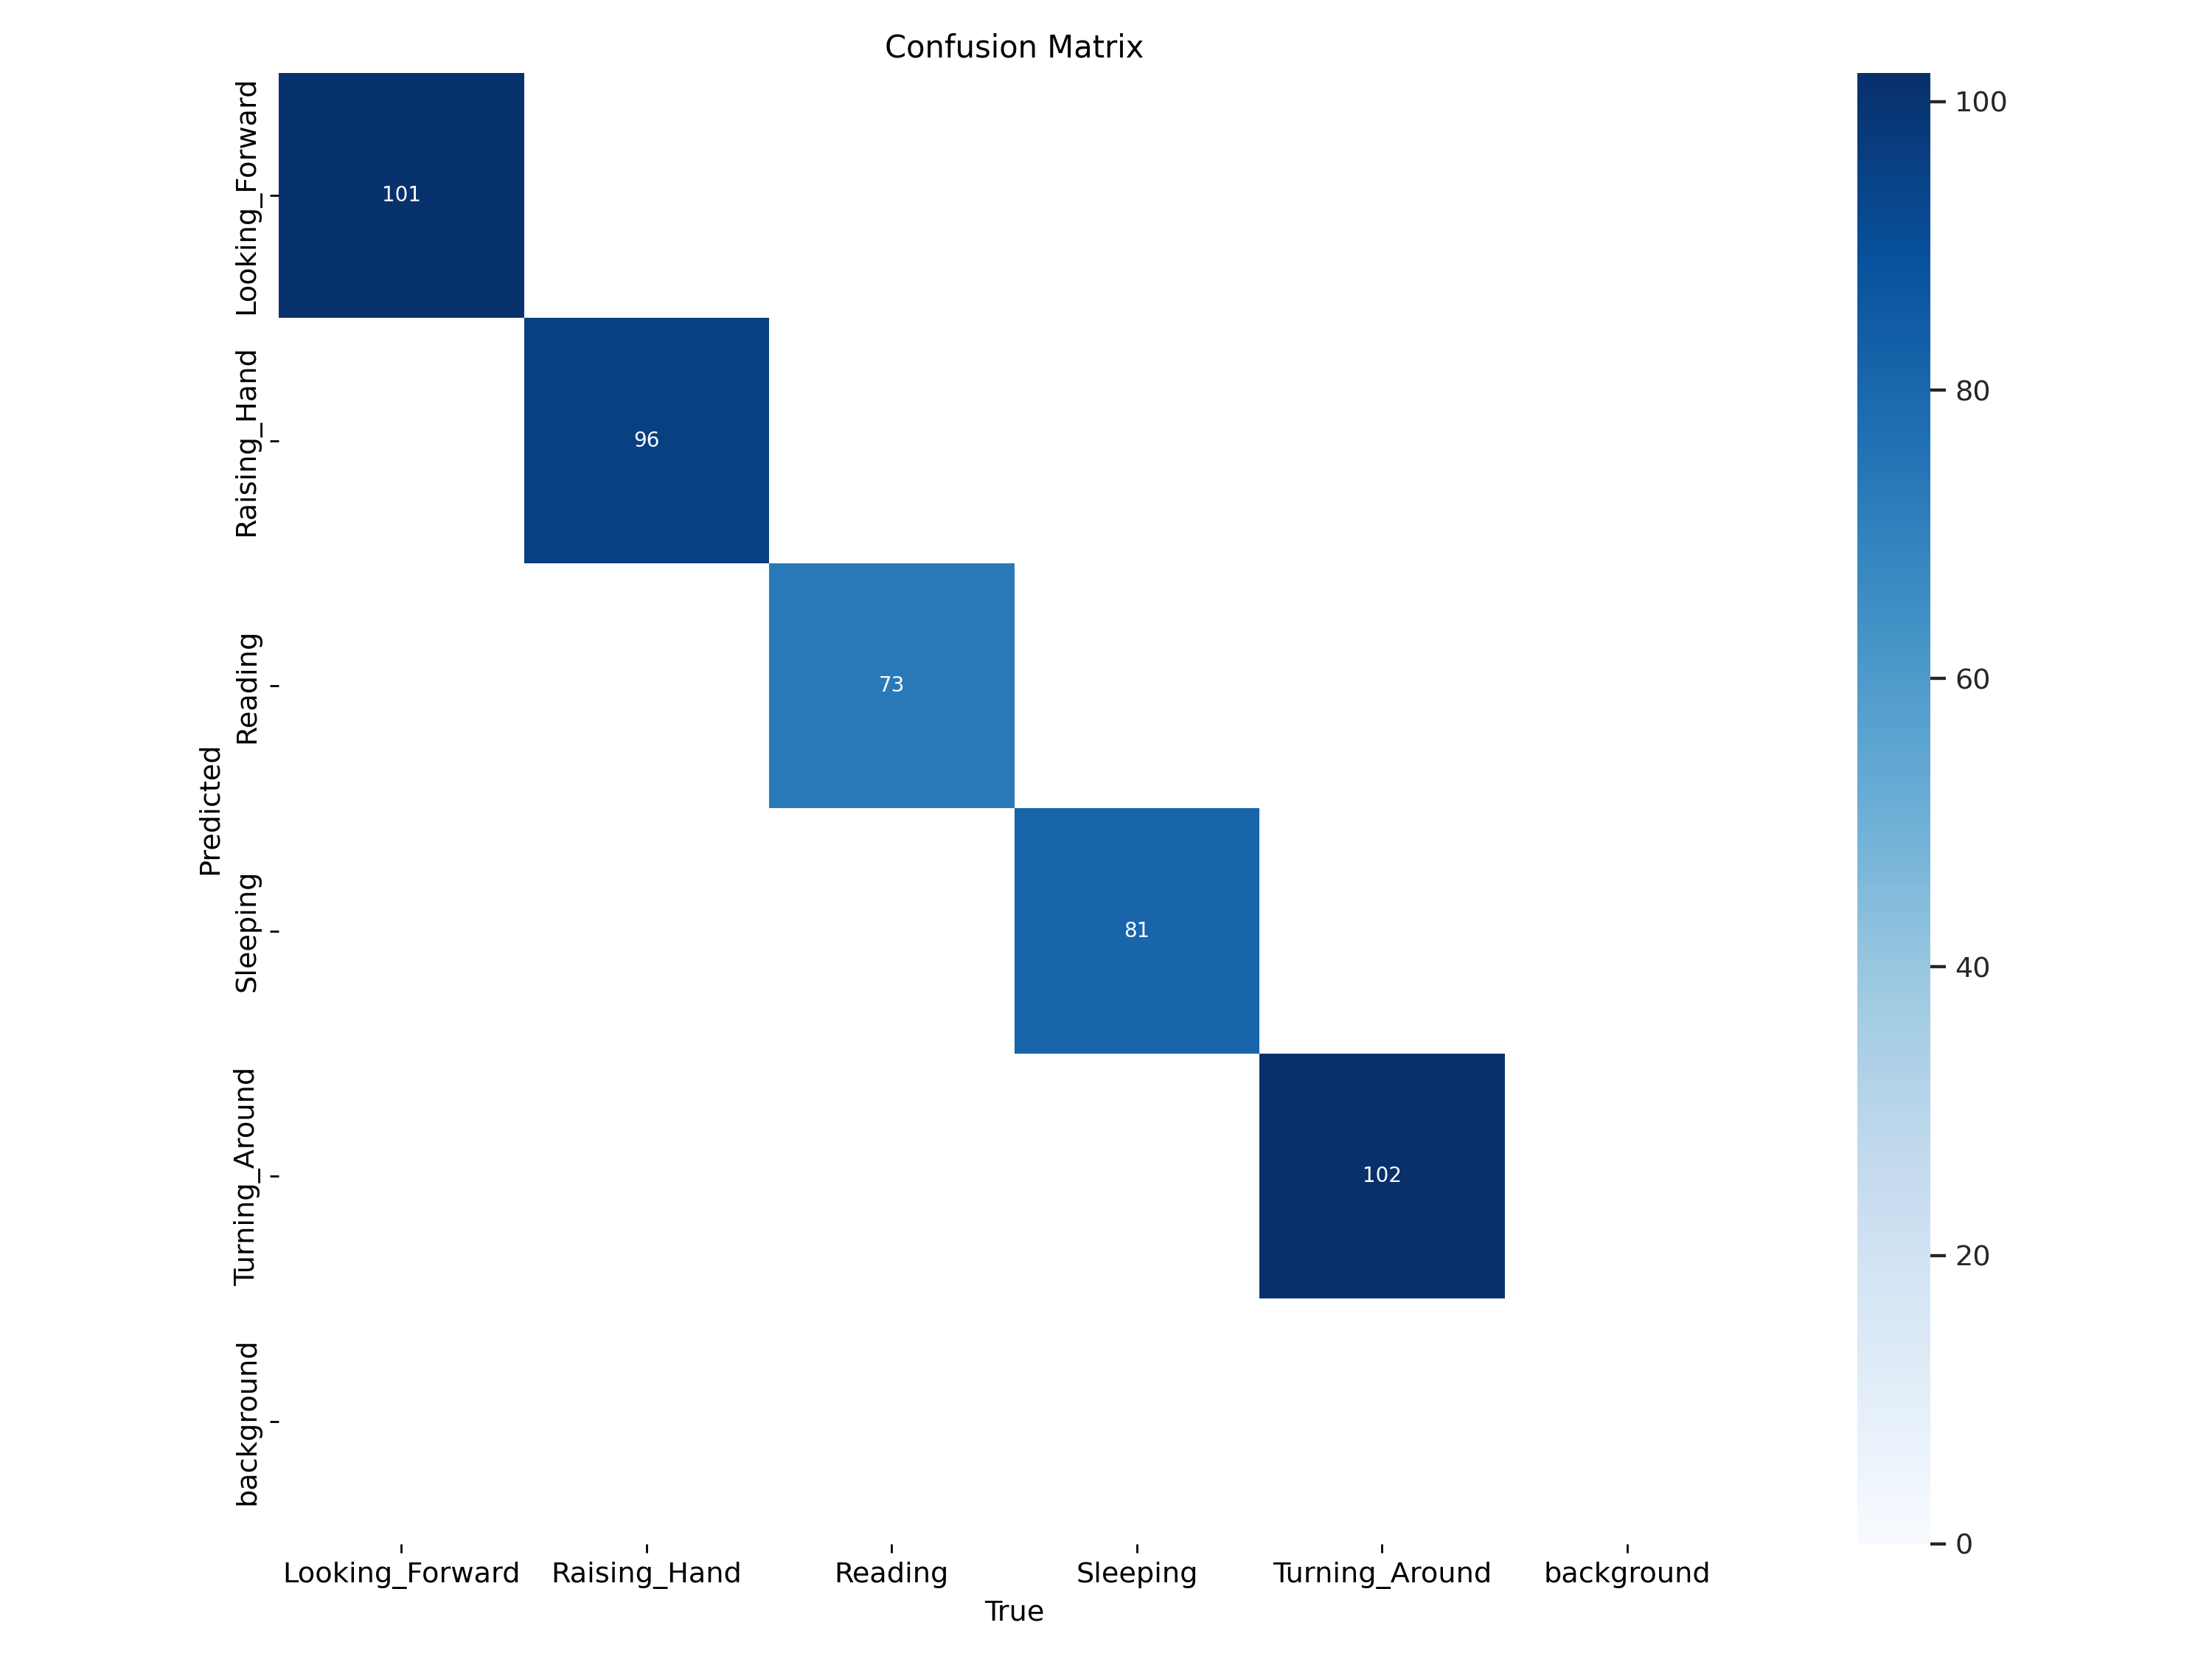

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=600)

/kaggle/working


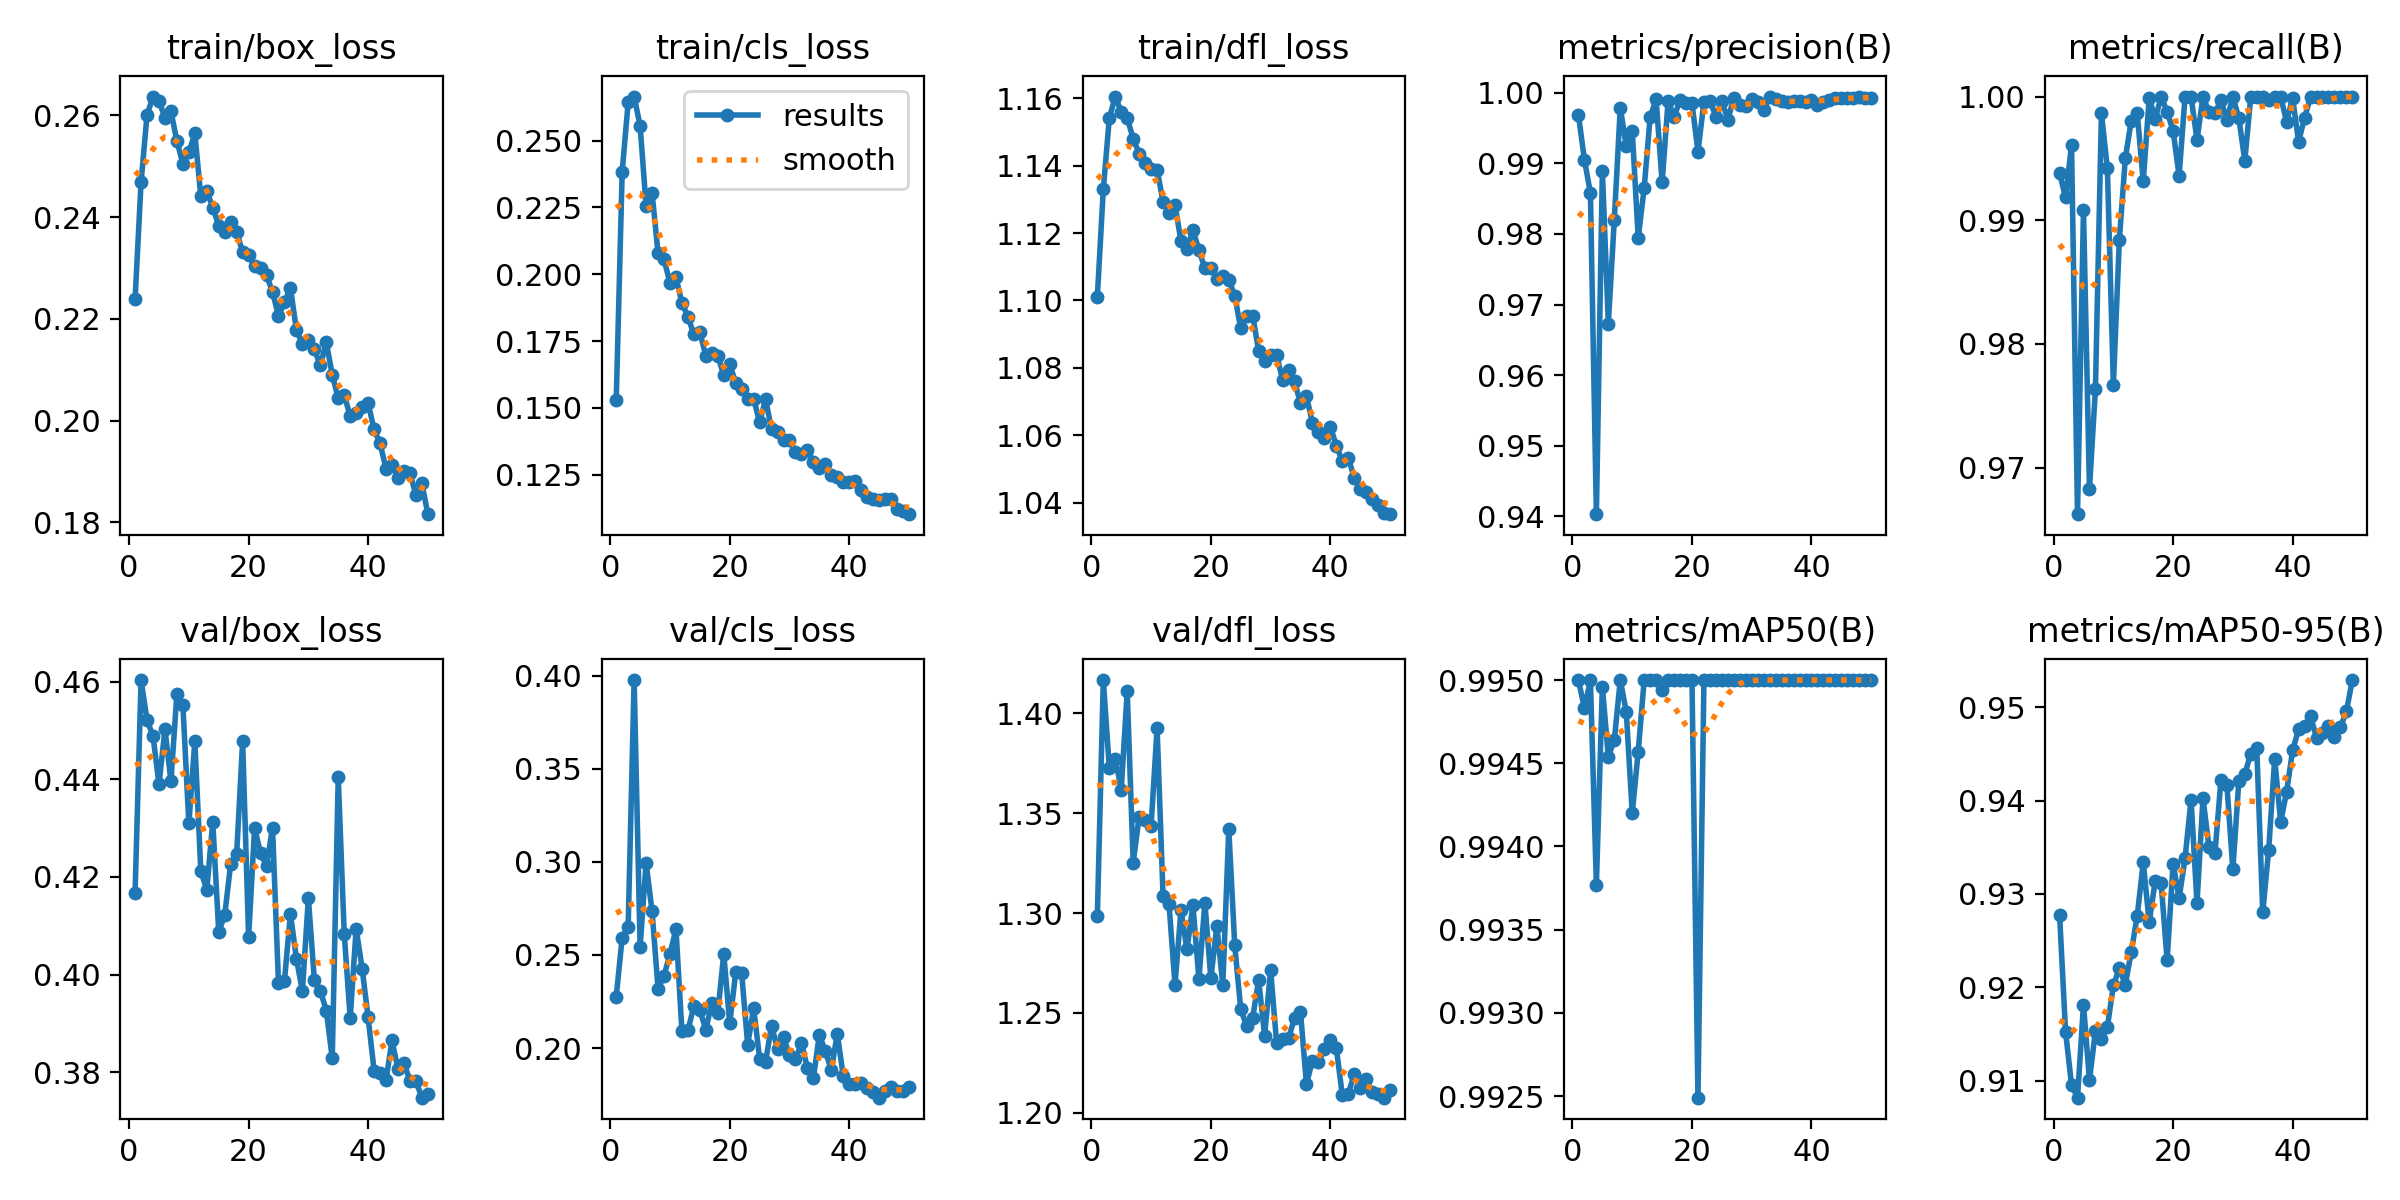

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/results.png', width=600)

/kaggle/working


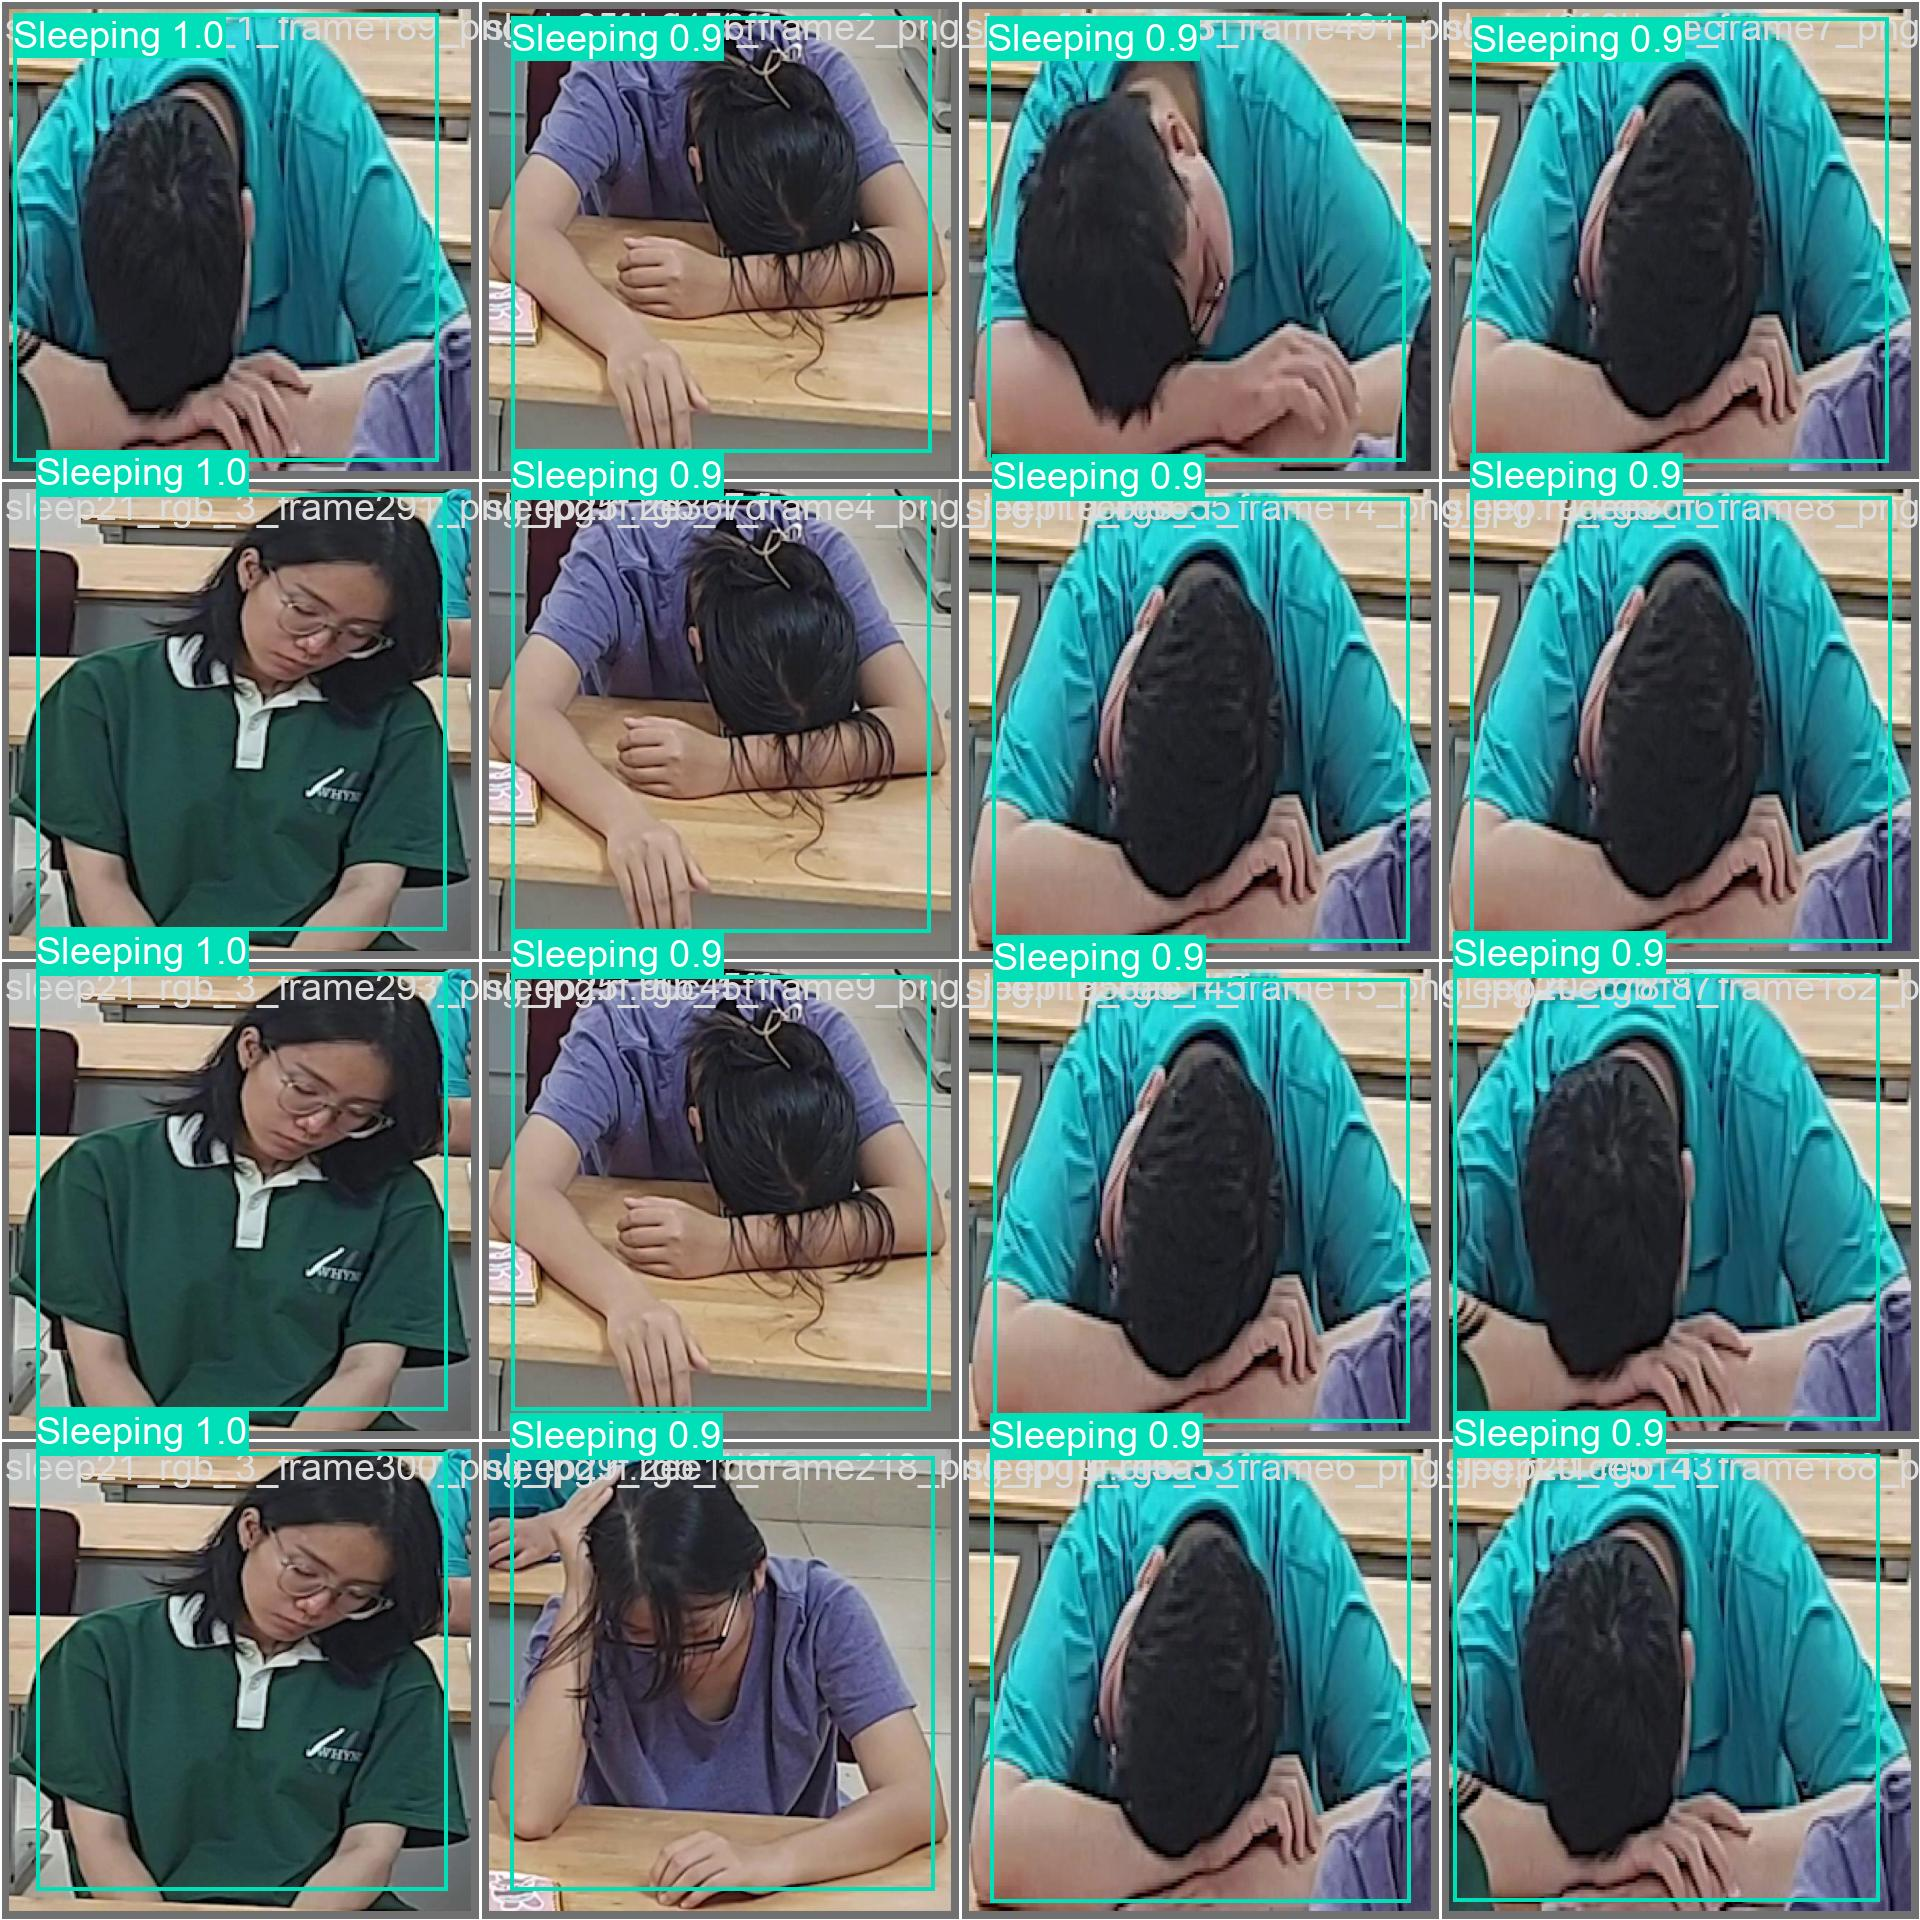

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=600)

/kaggle/working


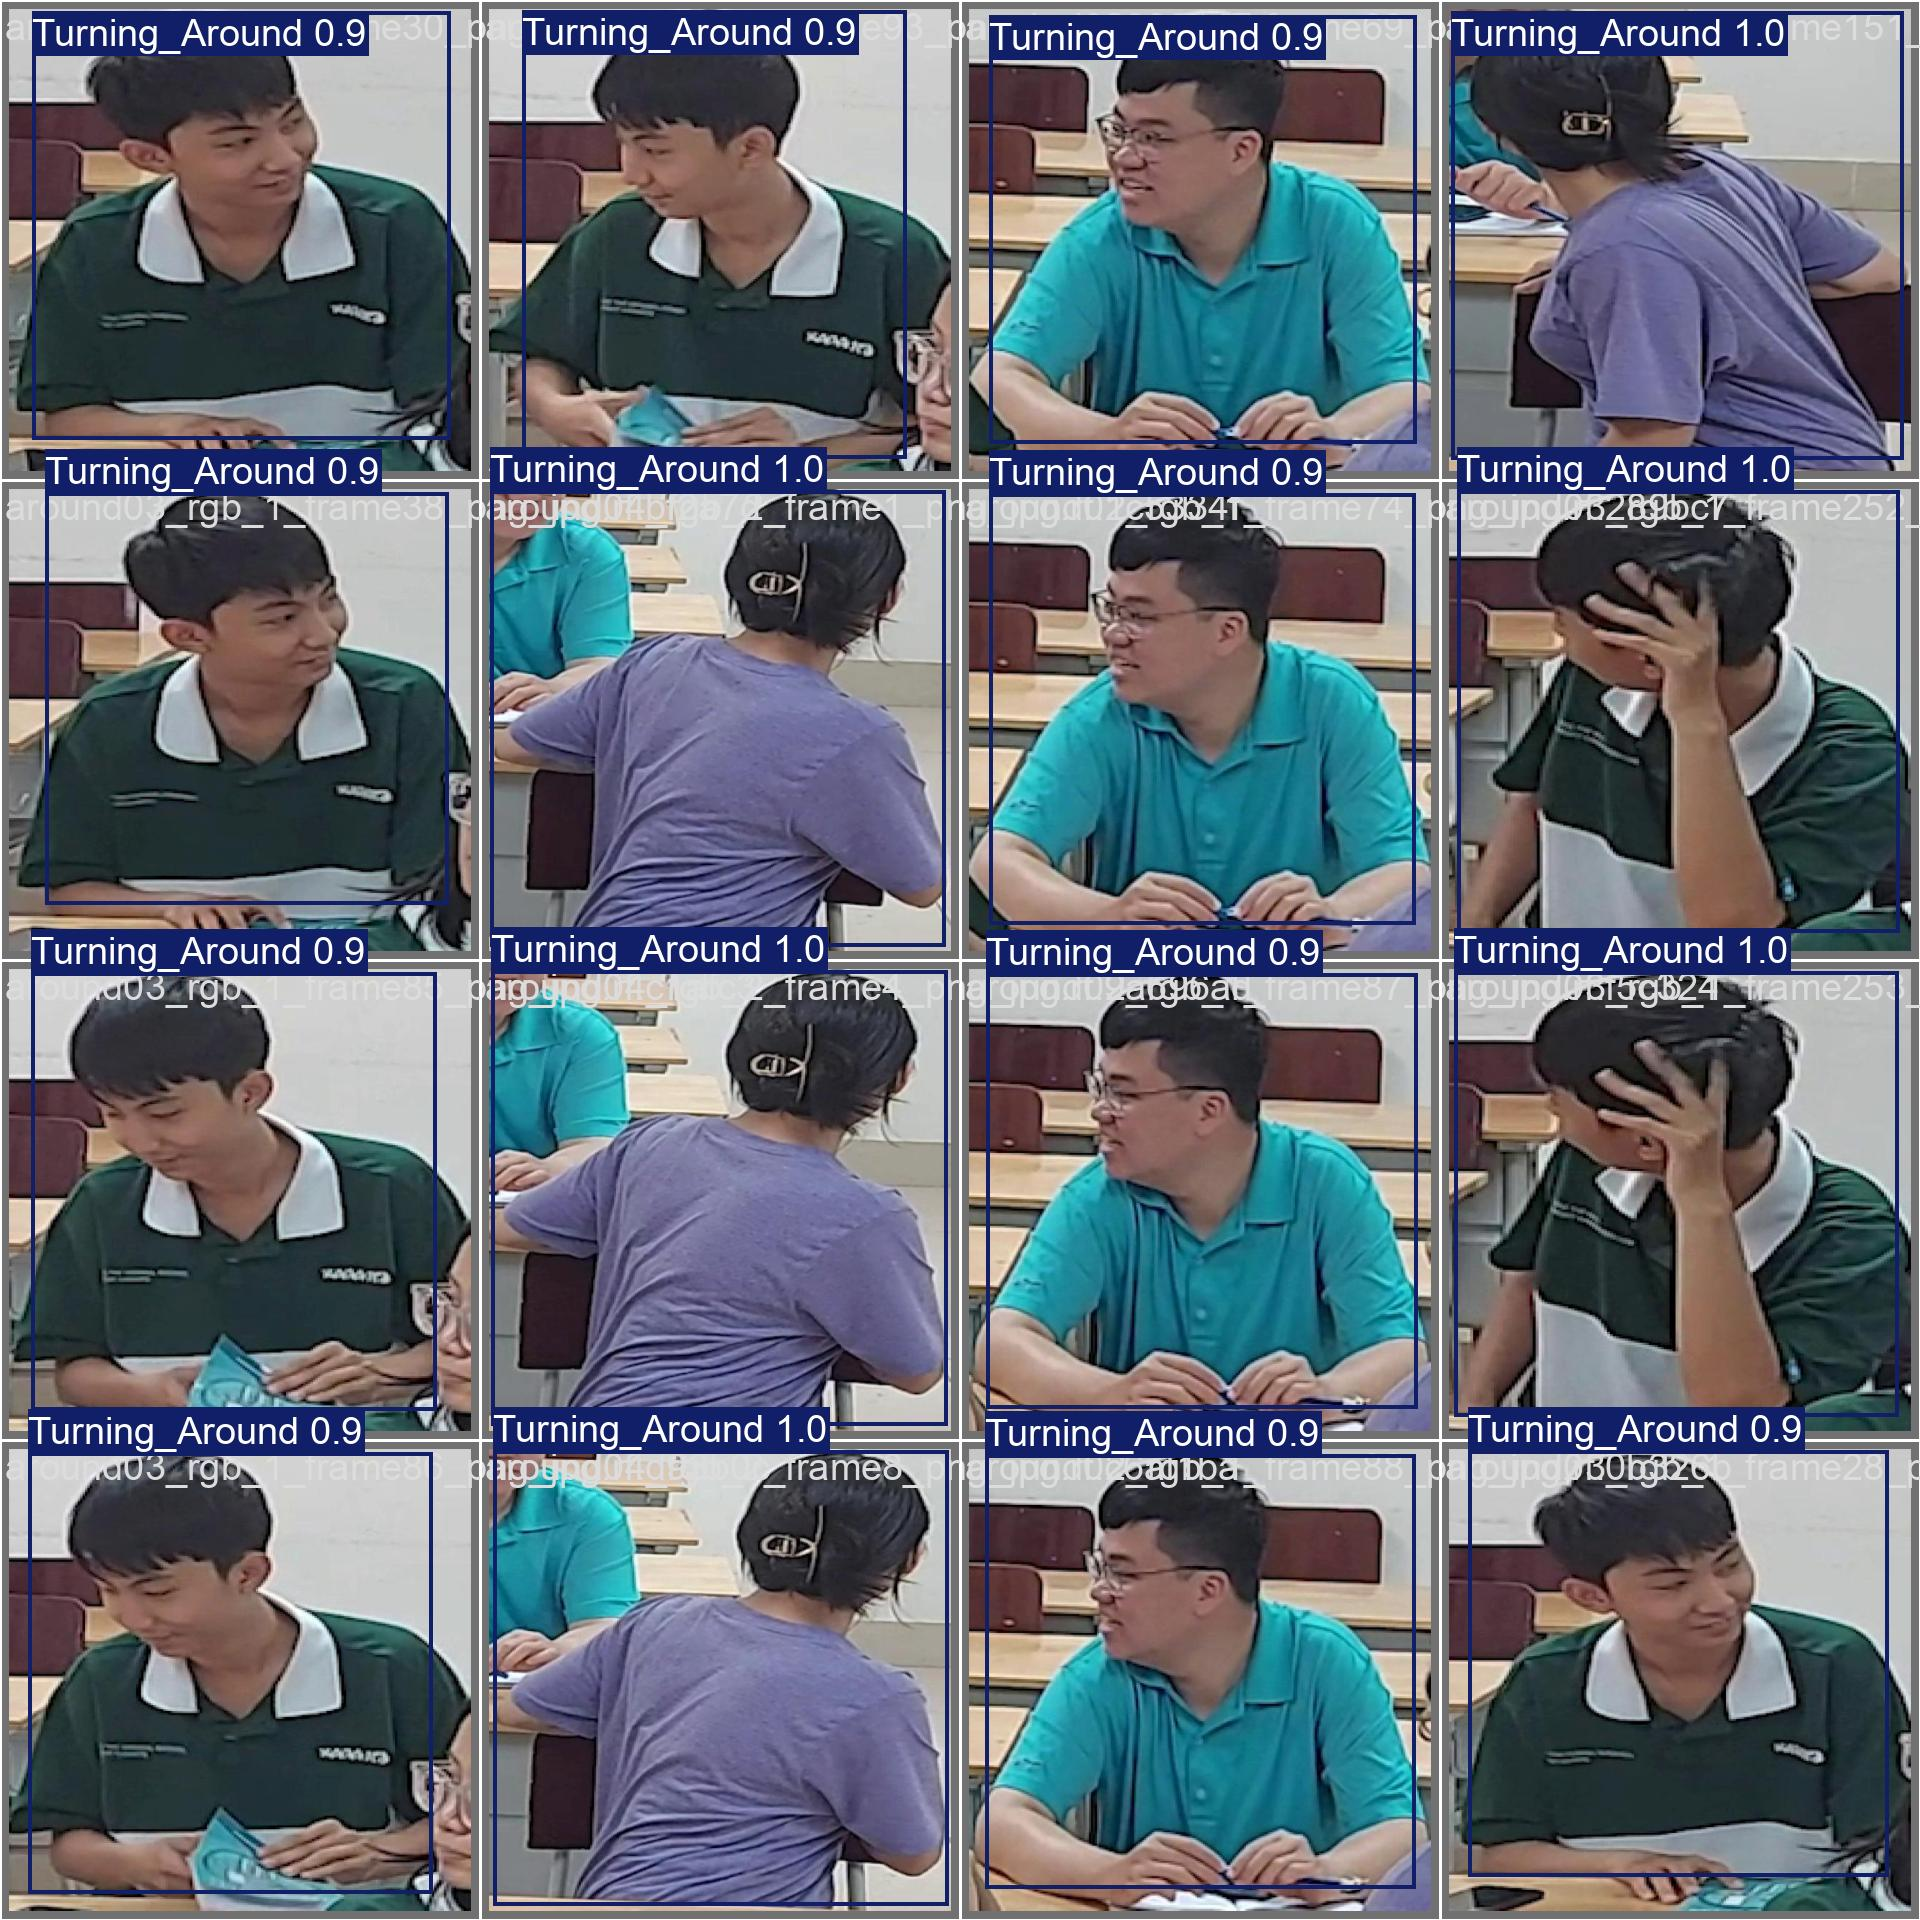

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/val_batch1_pred.jpg', width=600)

/kaggle/working


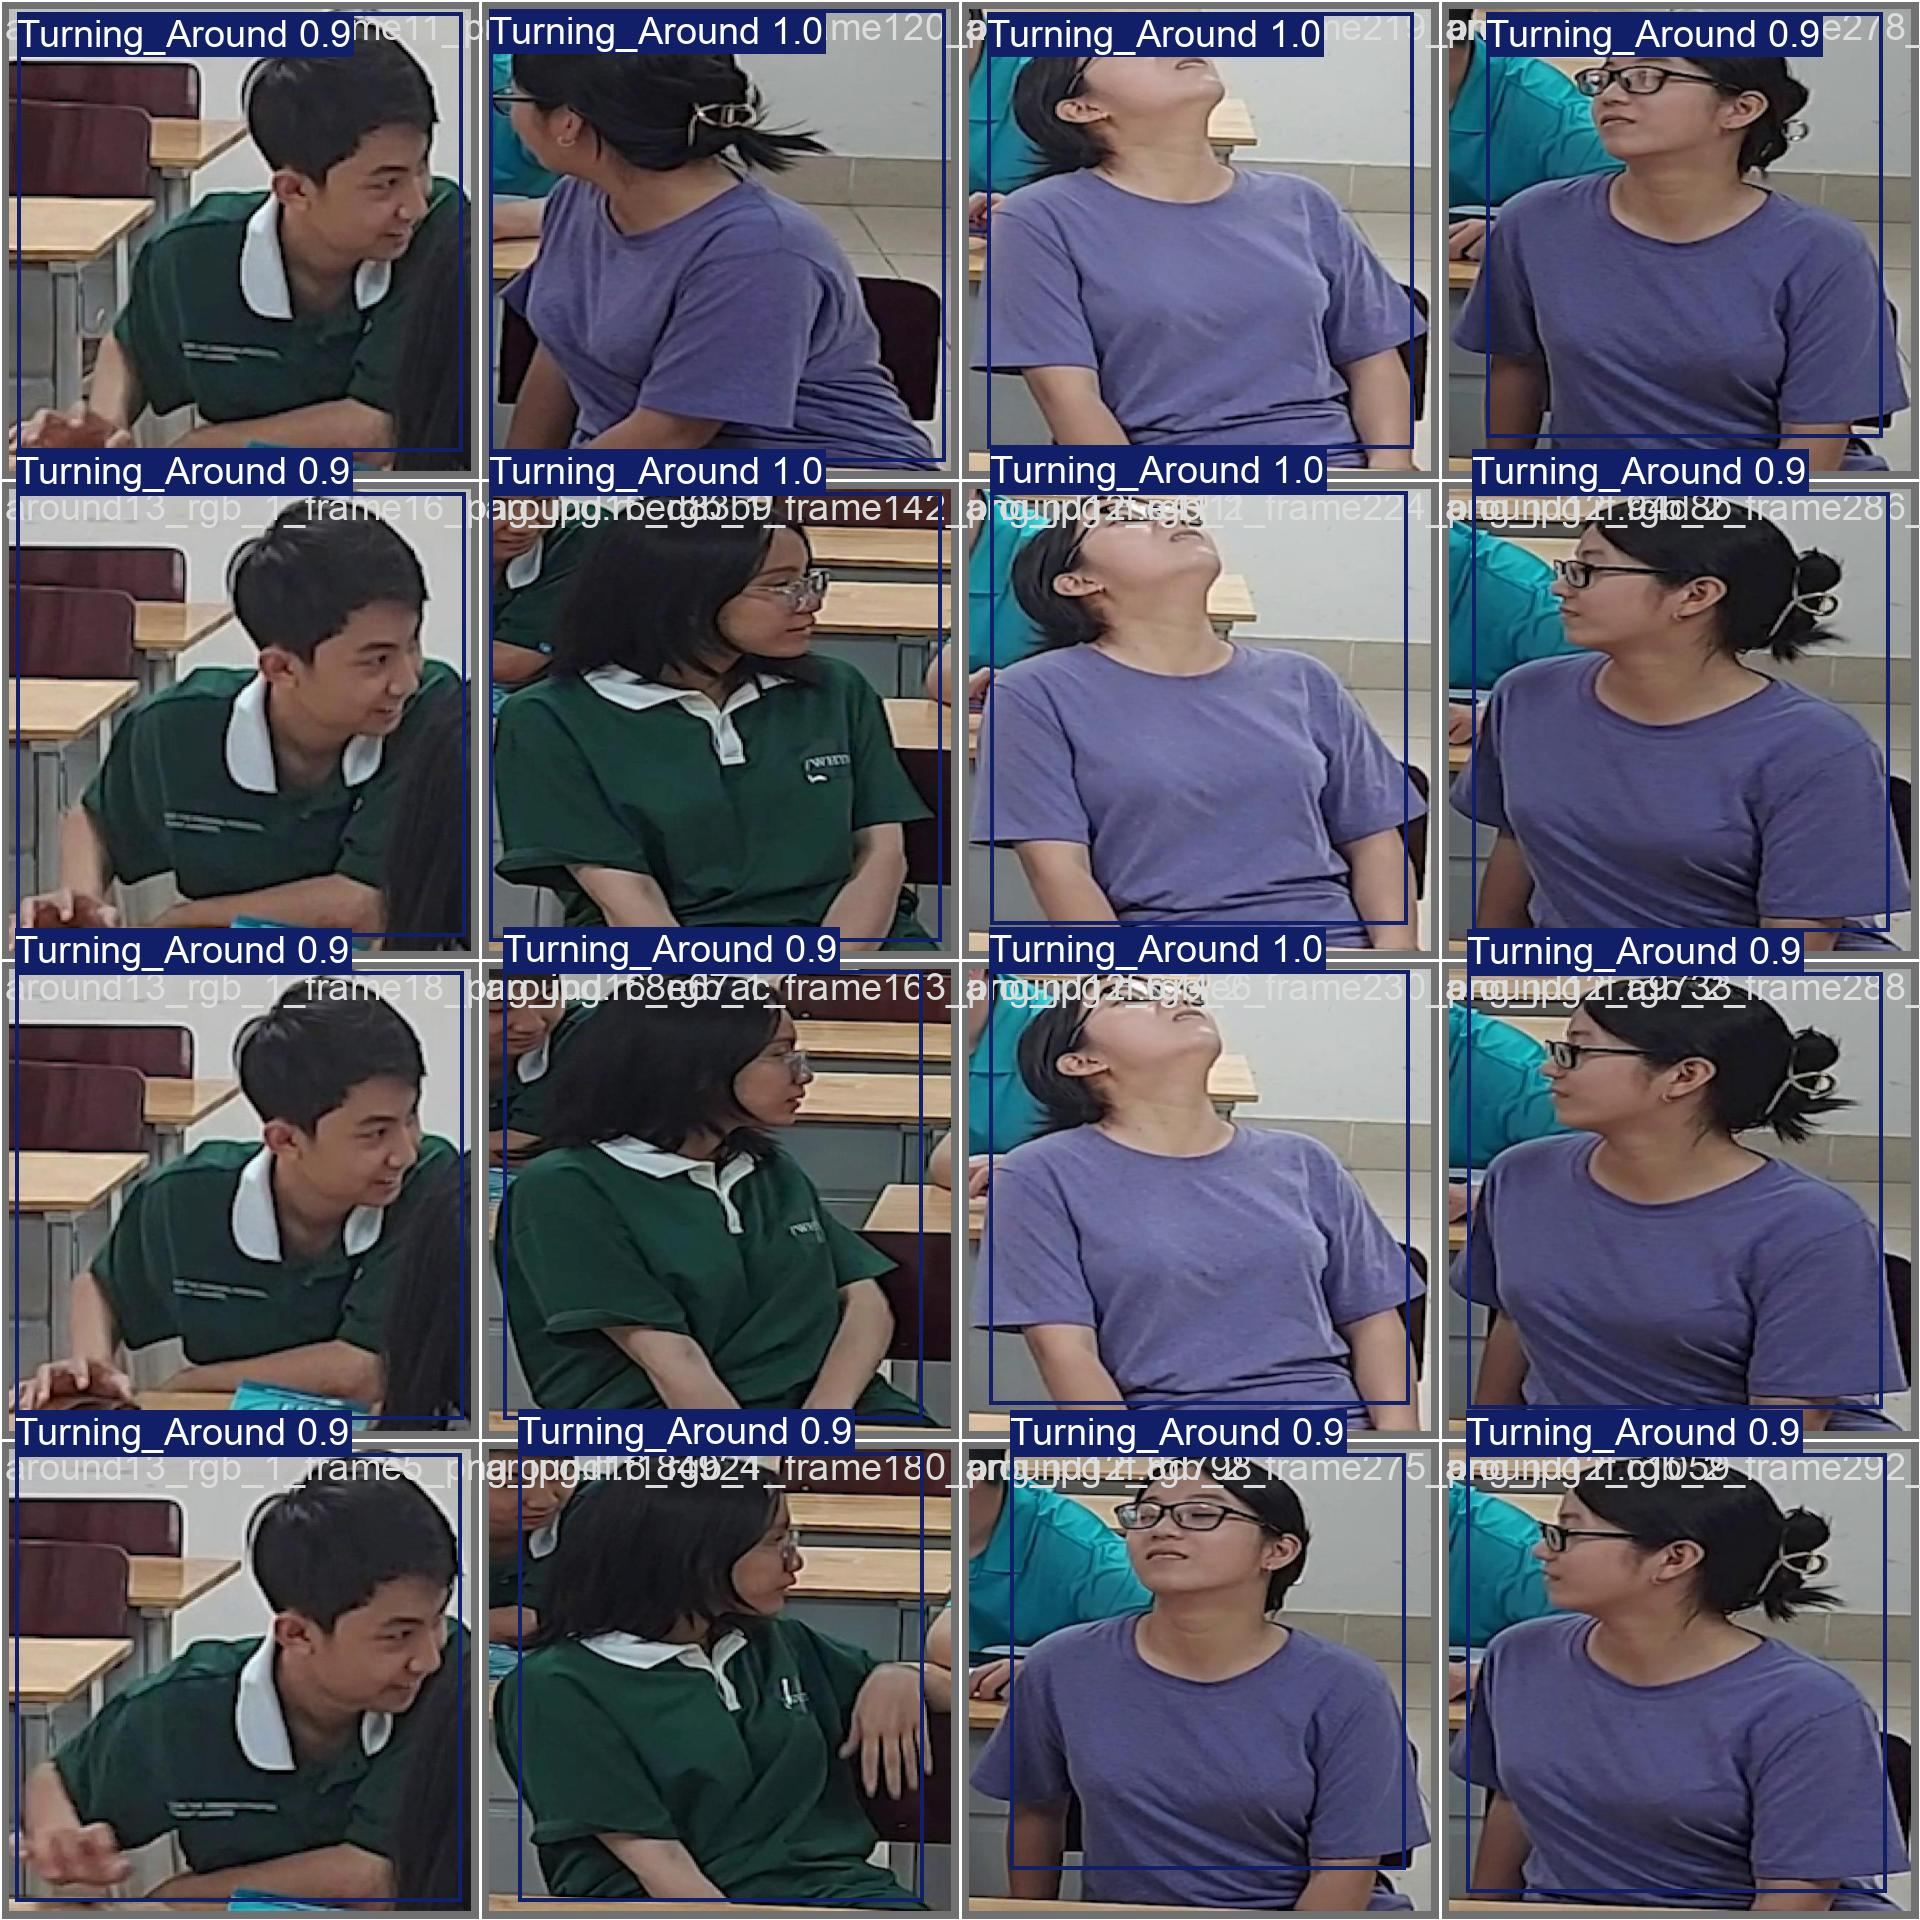

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/val_batch2_pred.jpg', width=600)

/kaggle/working


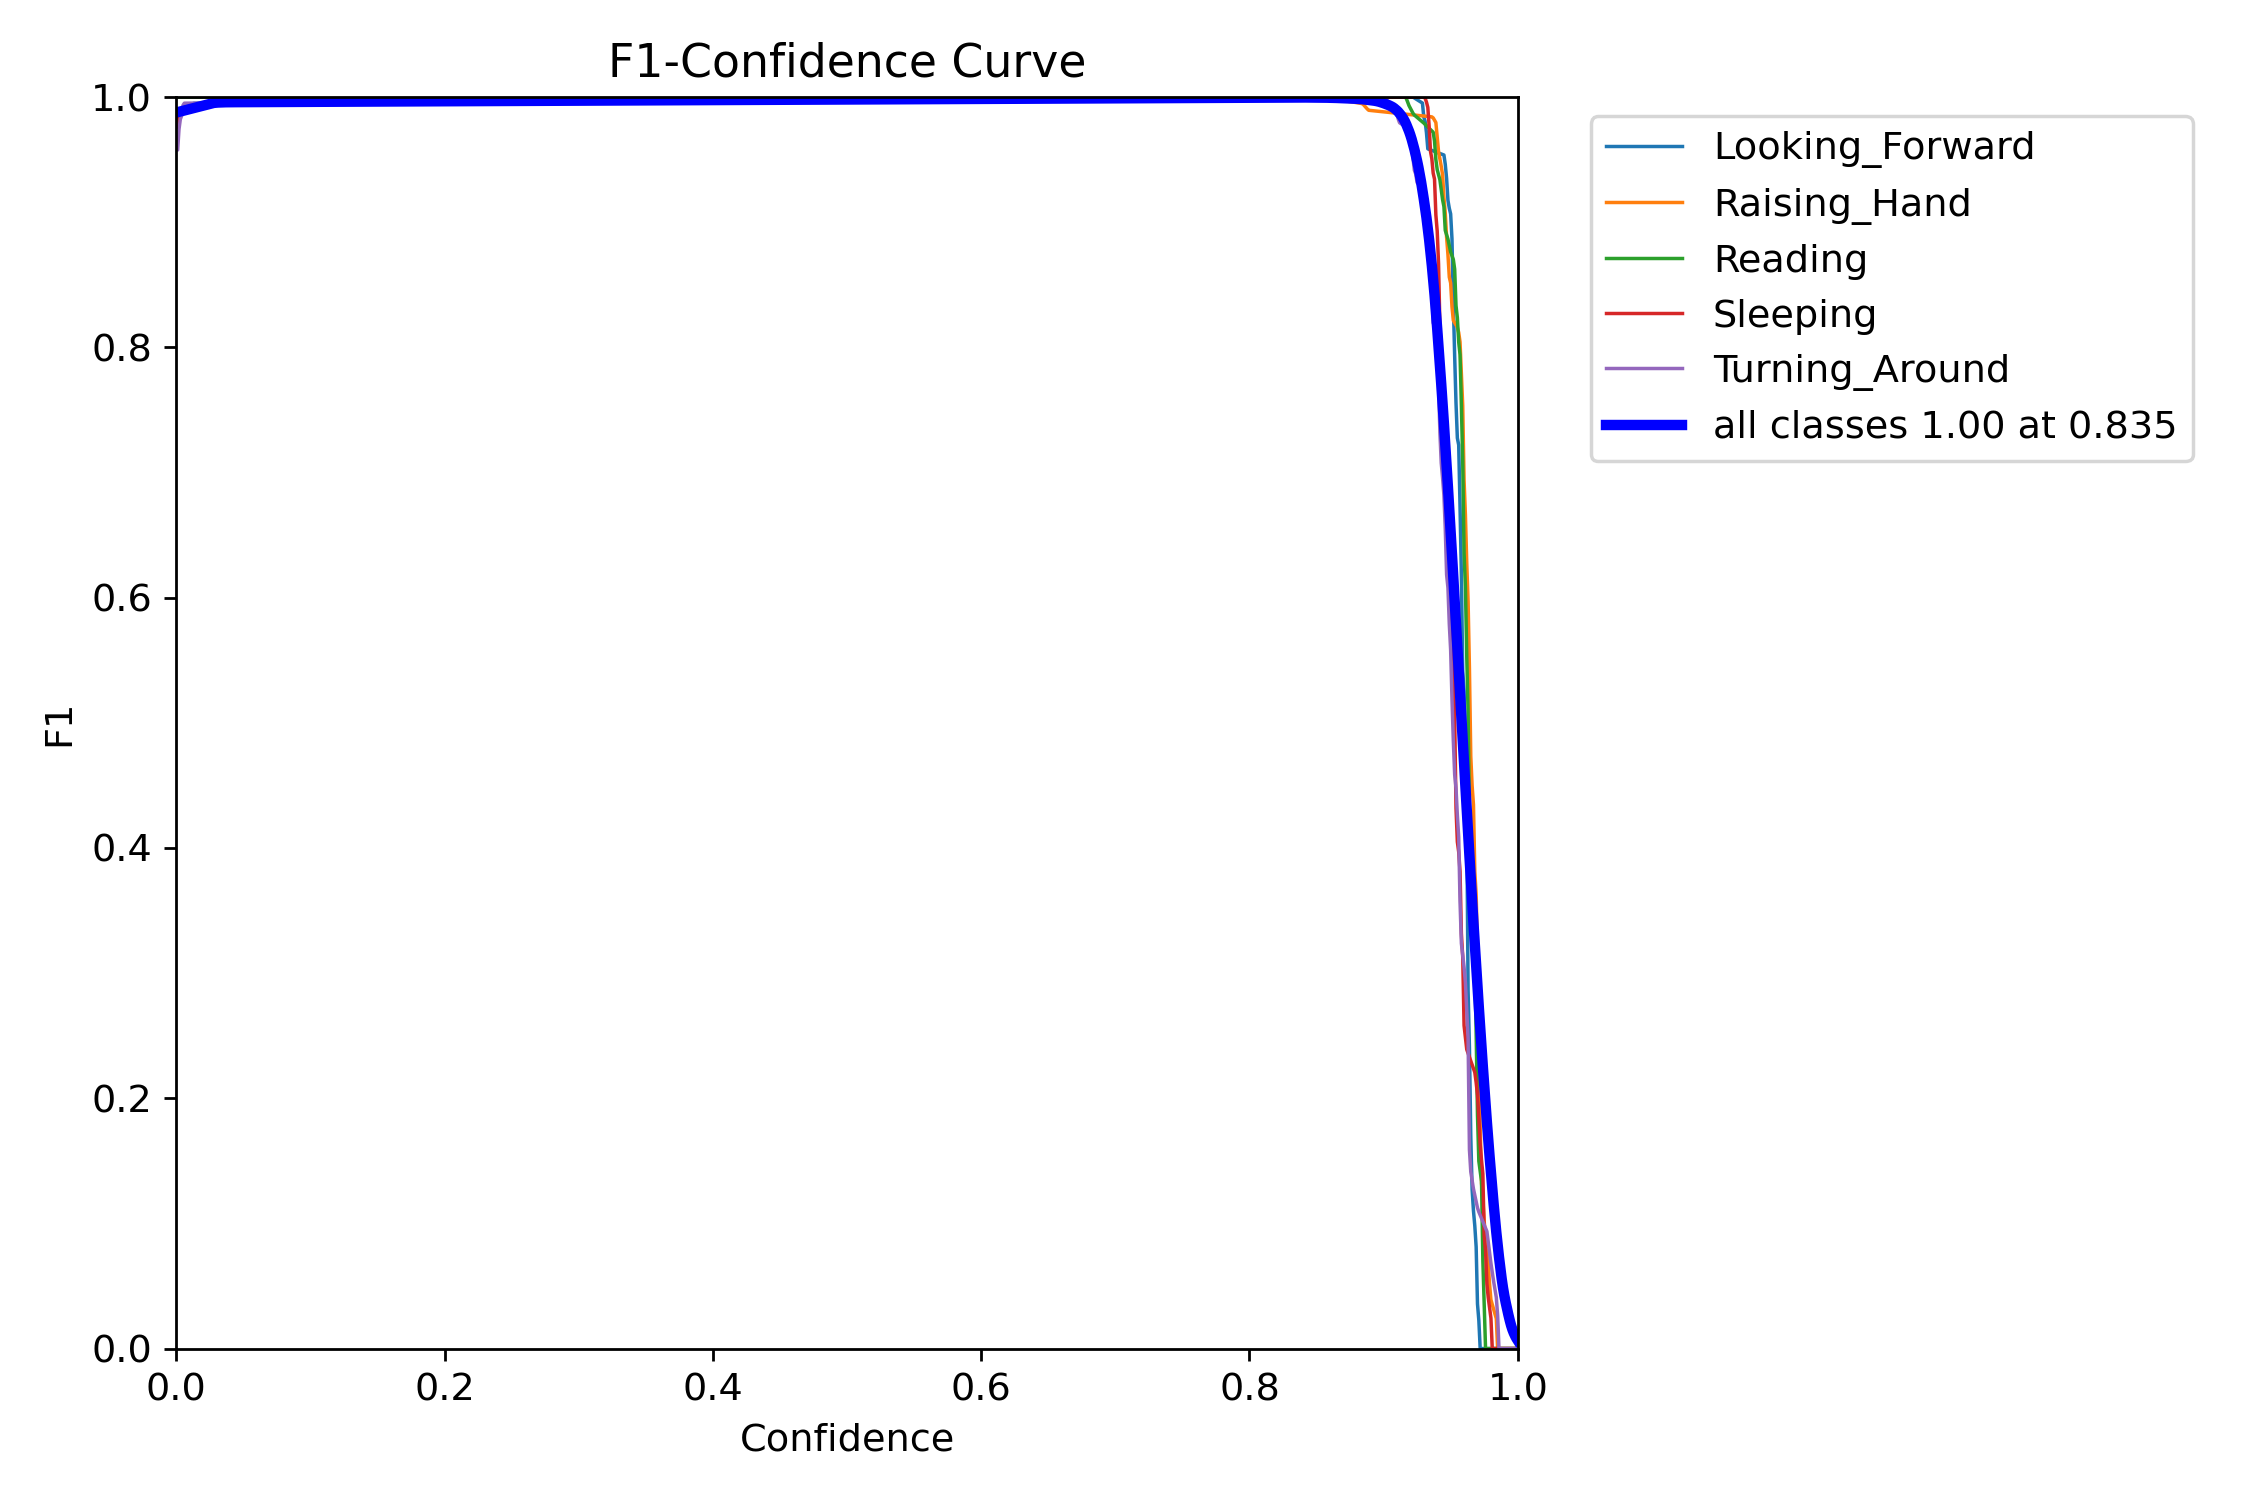

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/F1_curve.png', width=600)

/kaggle/working


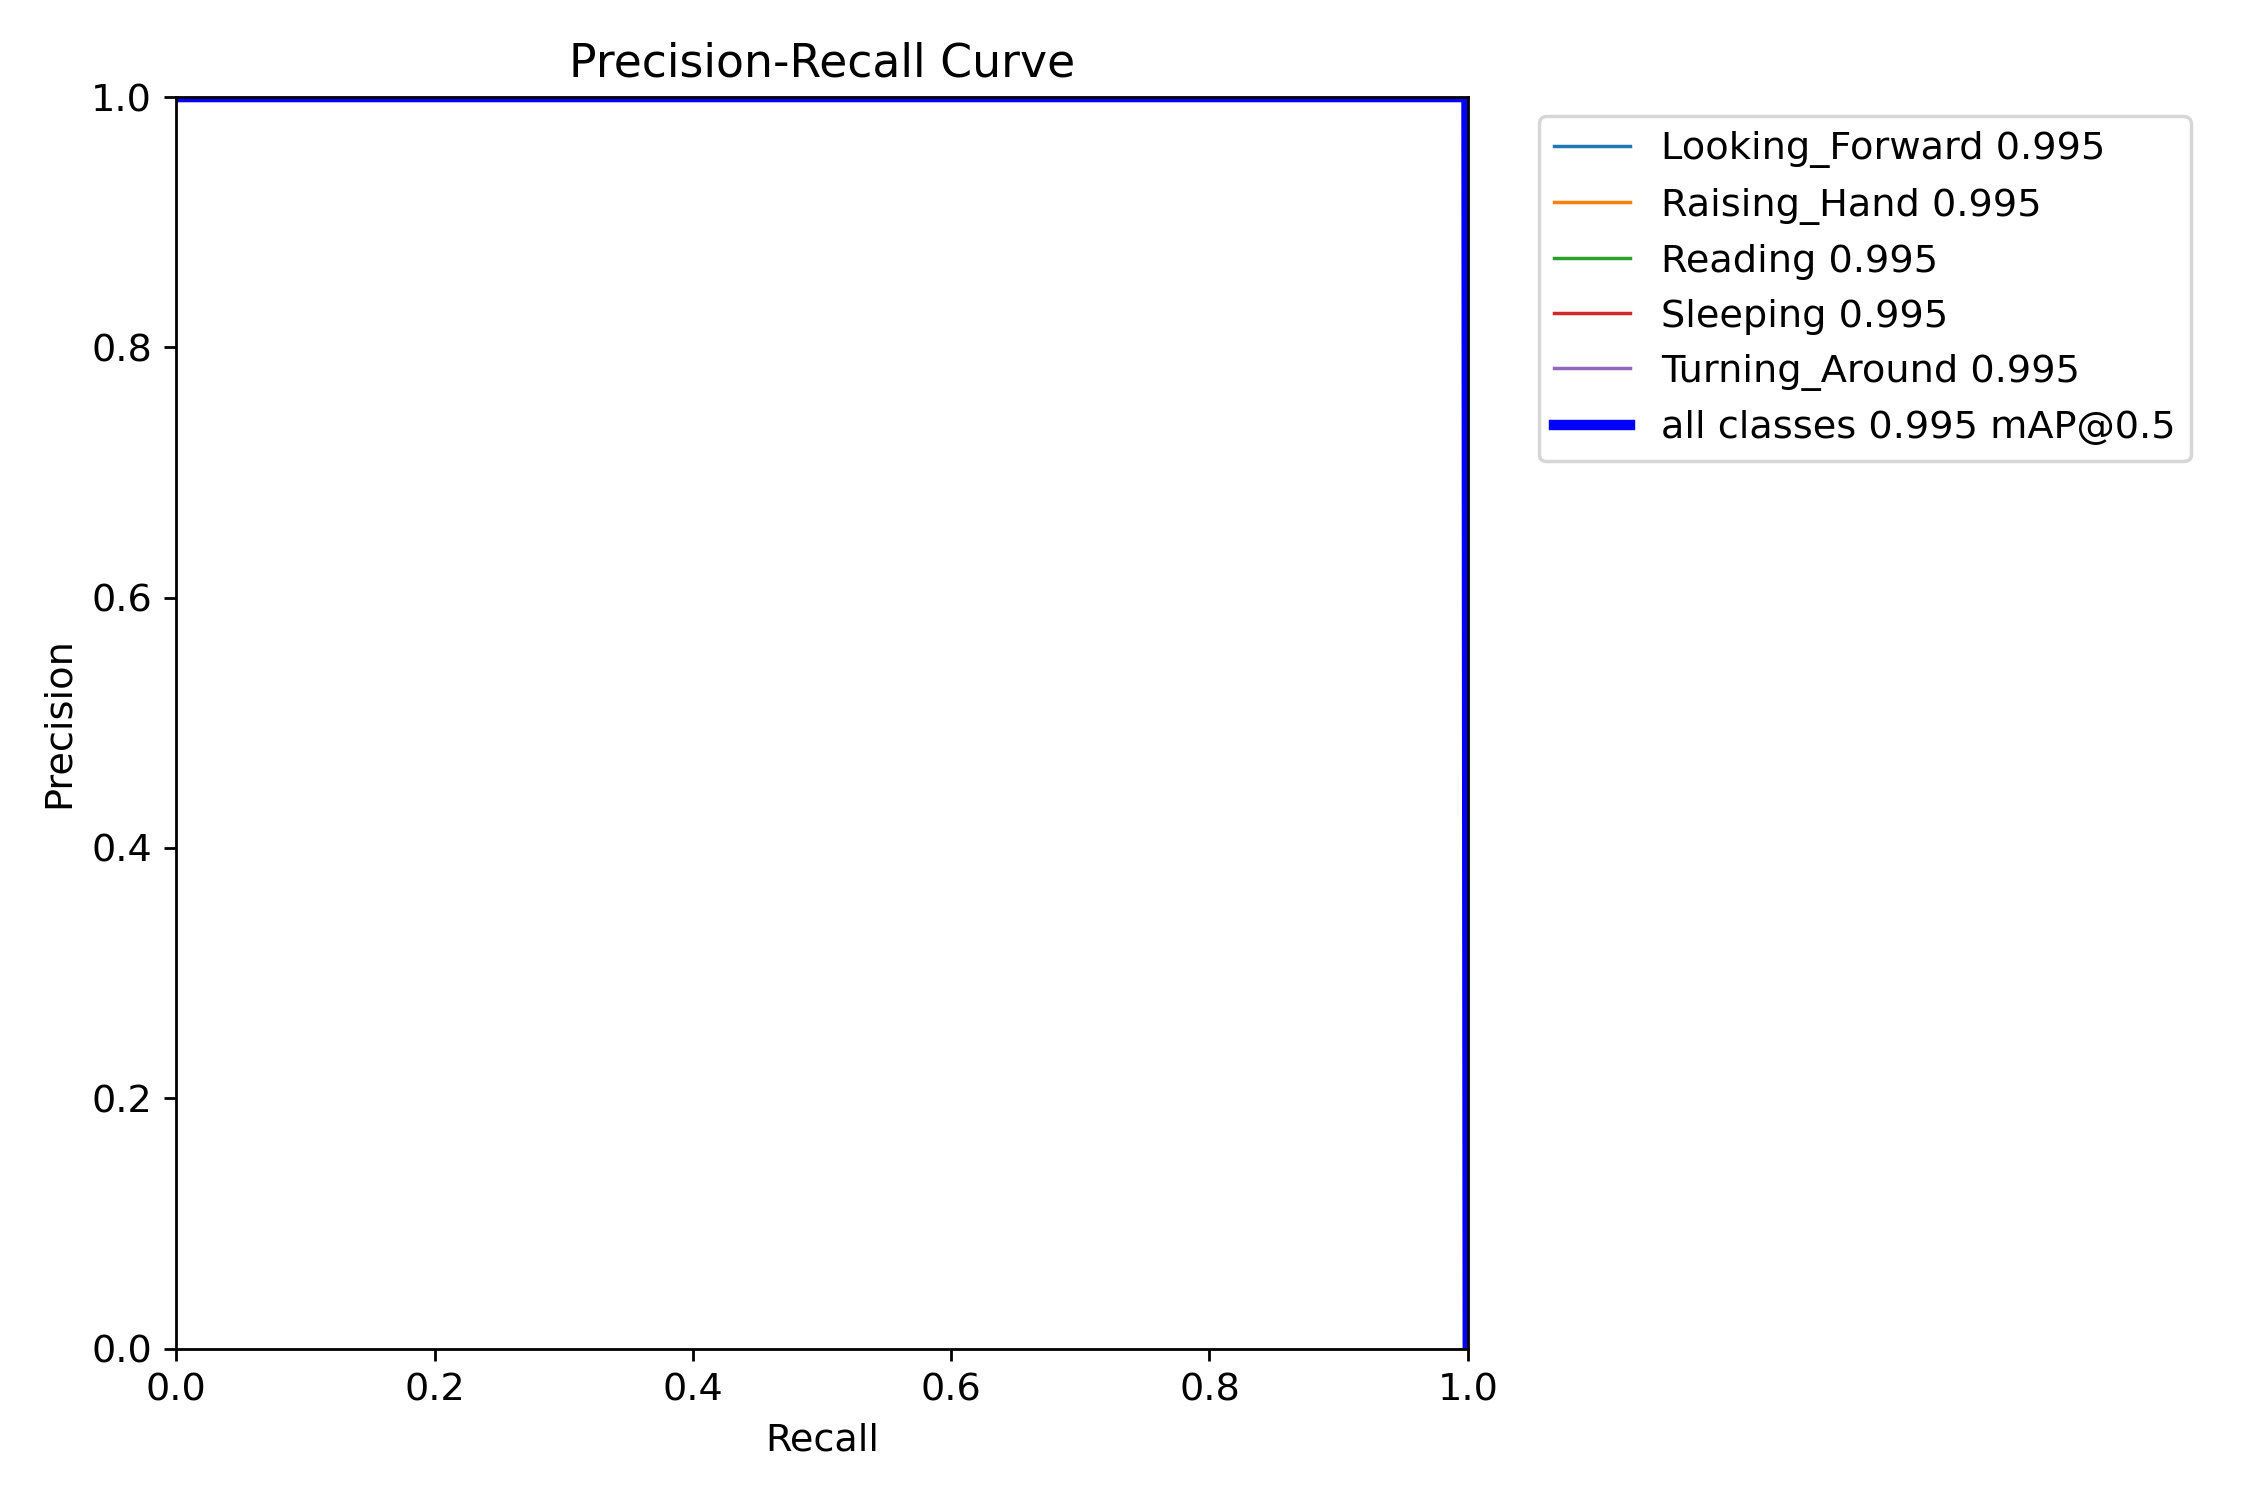

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/PR_curve.png', width=600)

/kaggle/working


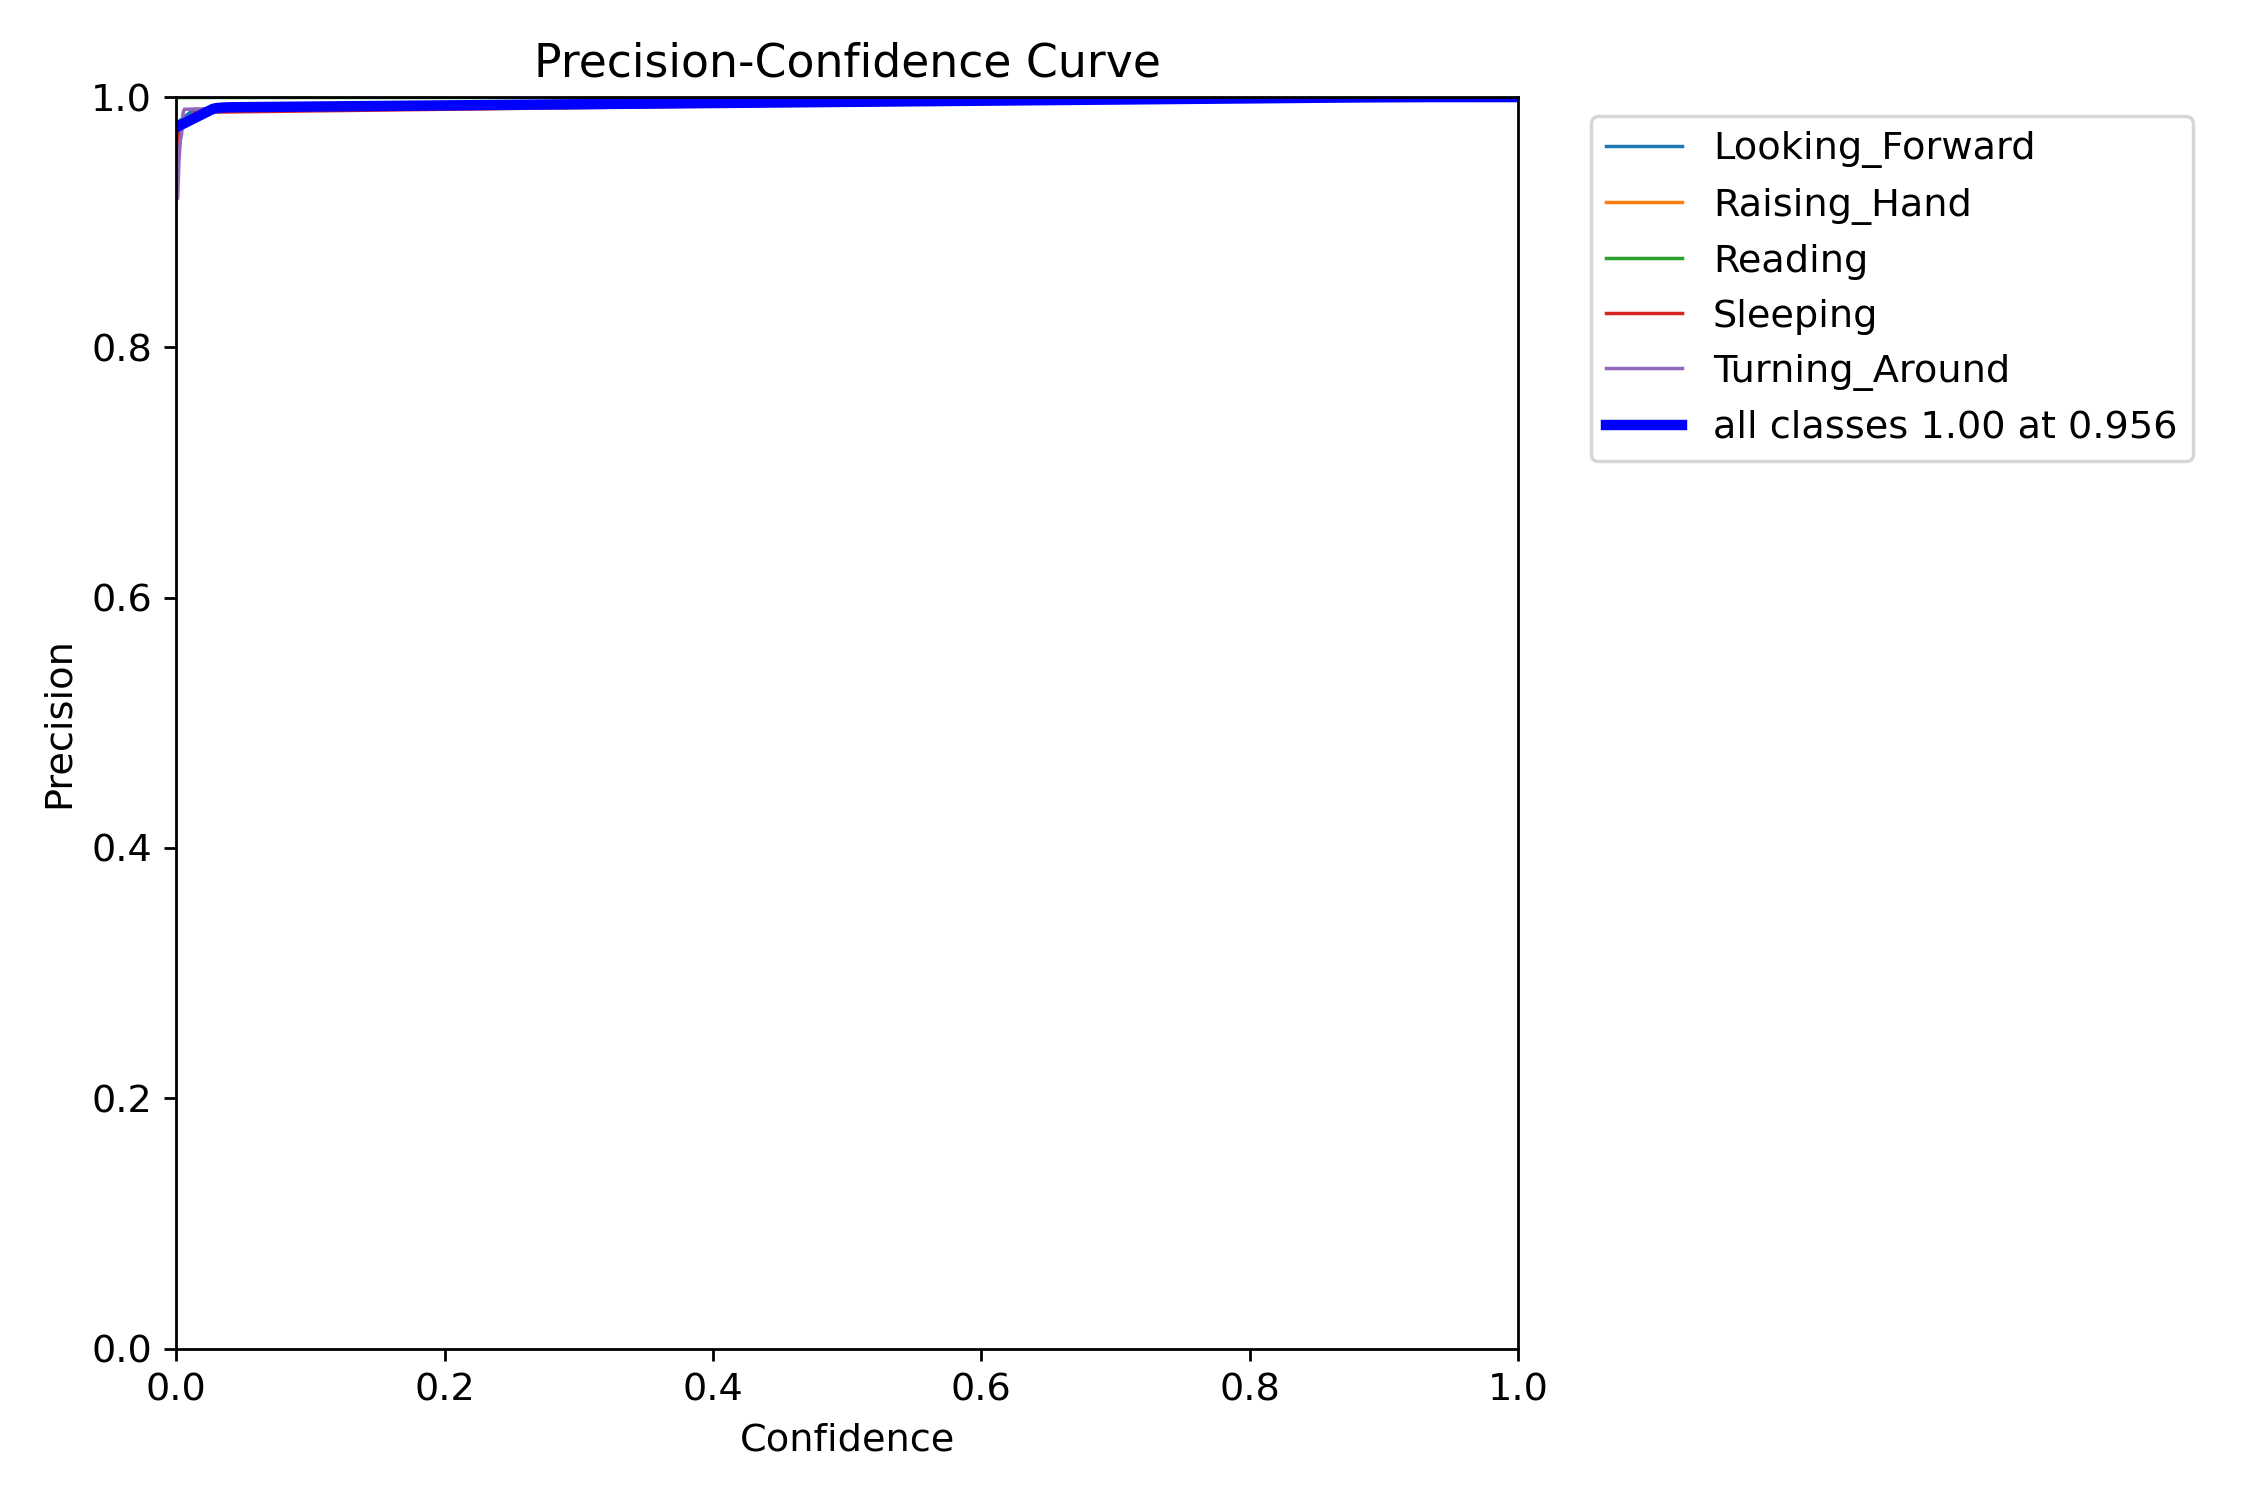

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/P_curve.png', width=600)

/kaggle/working


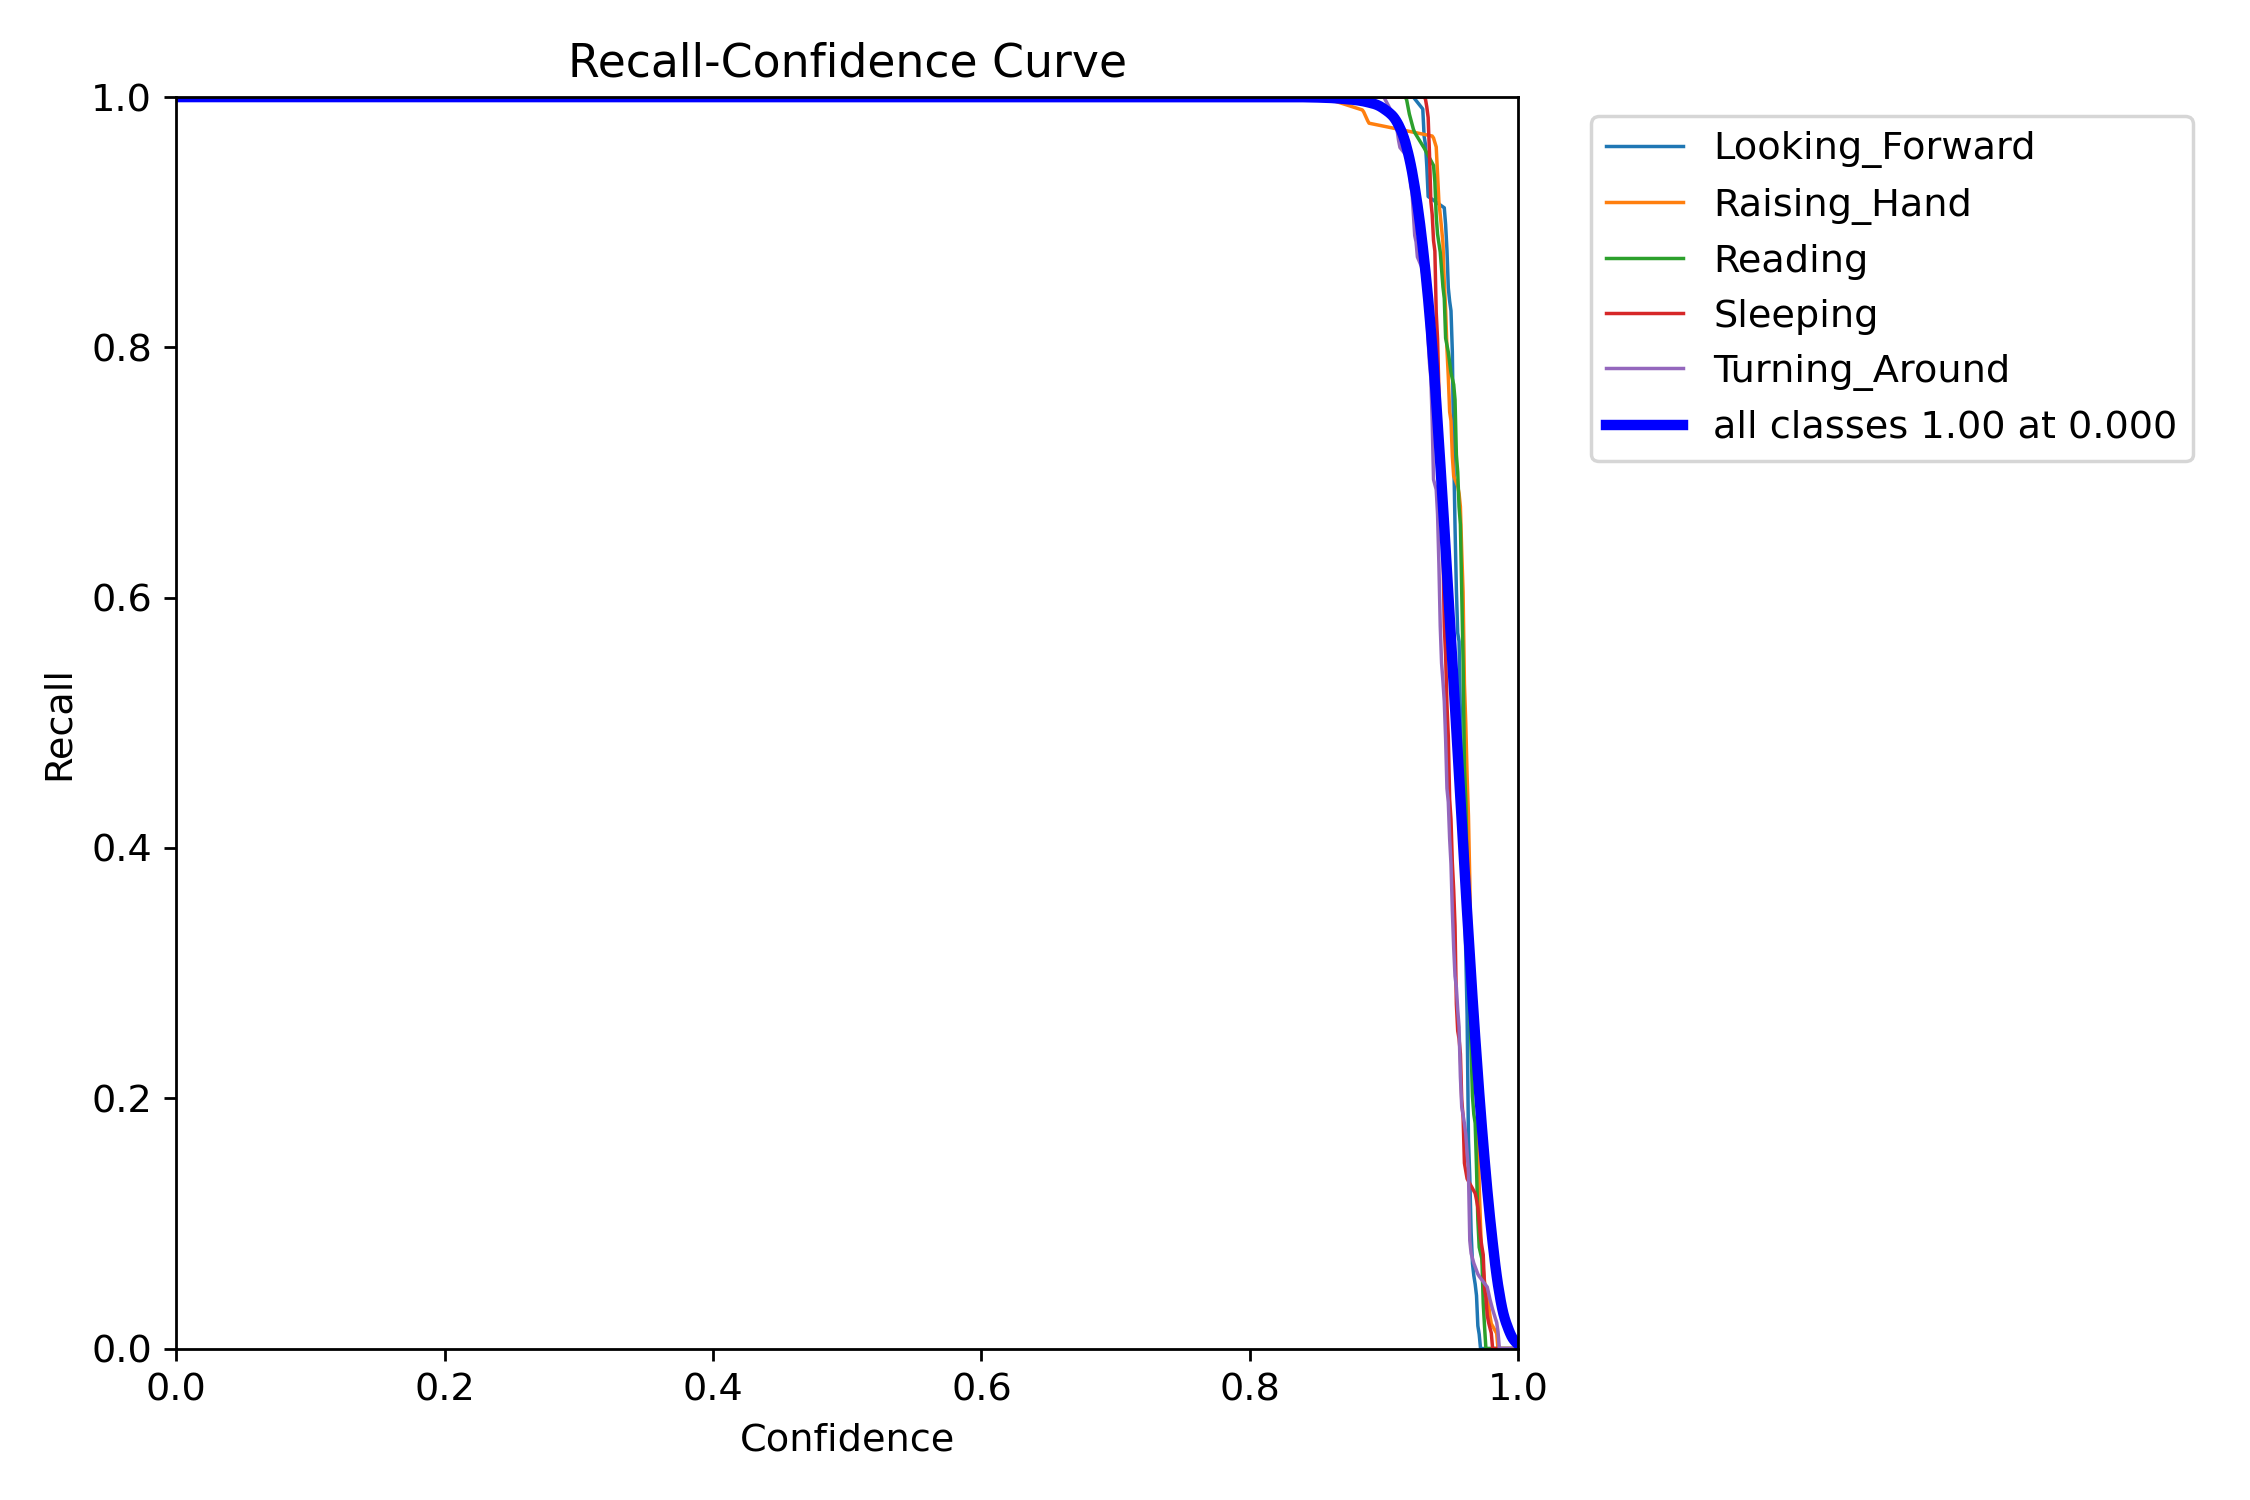

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/R_curve.png', width=600)

/kaggle/working


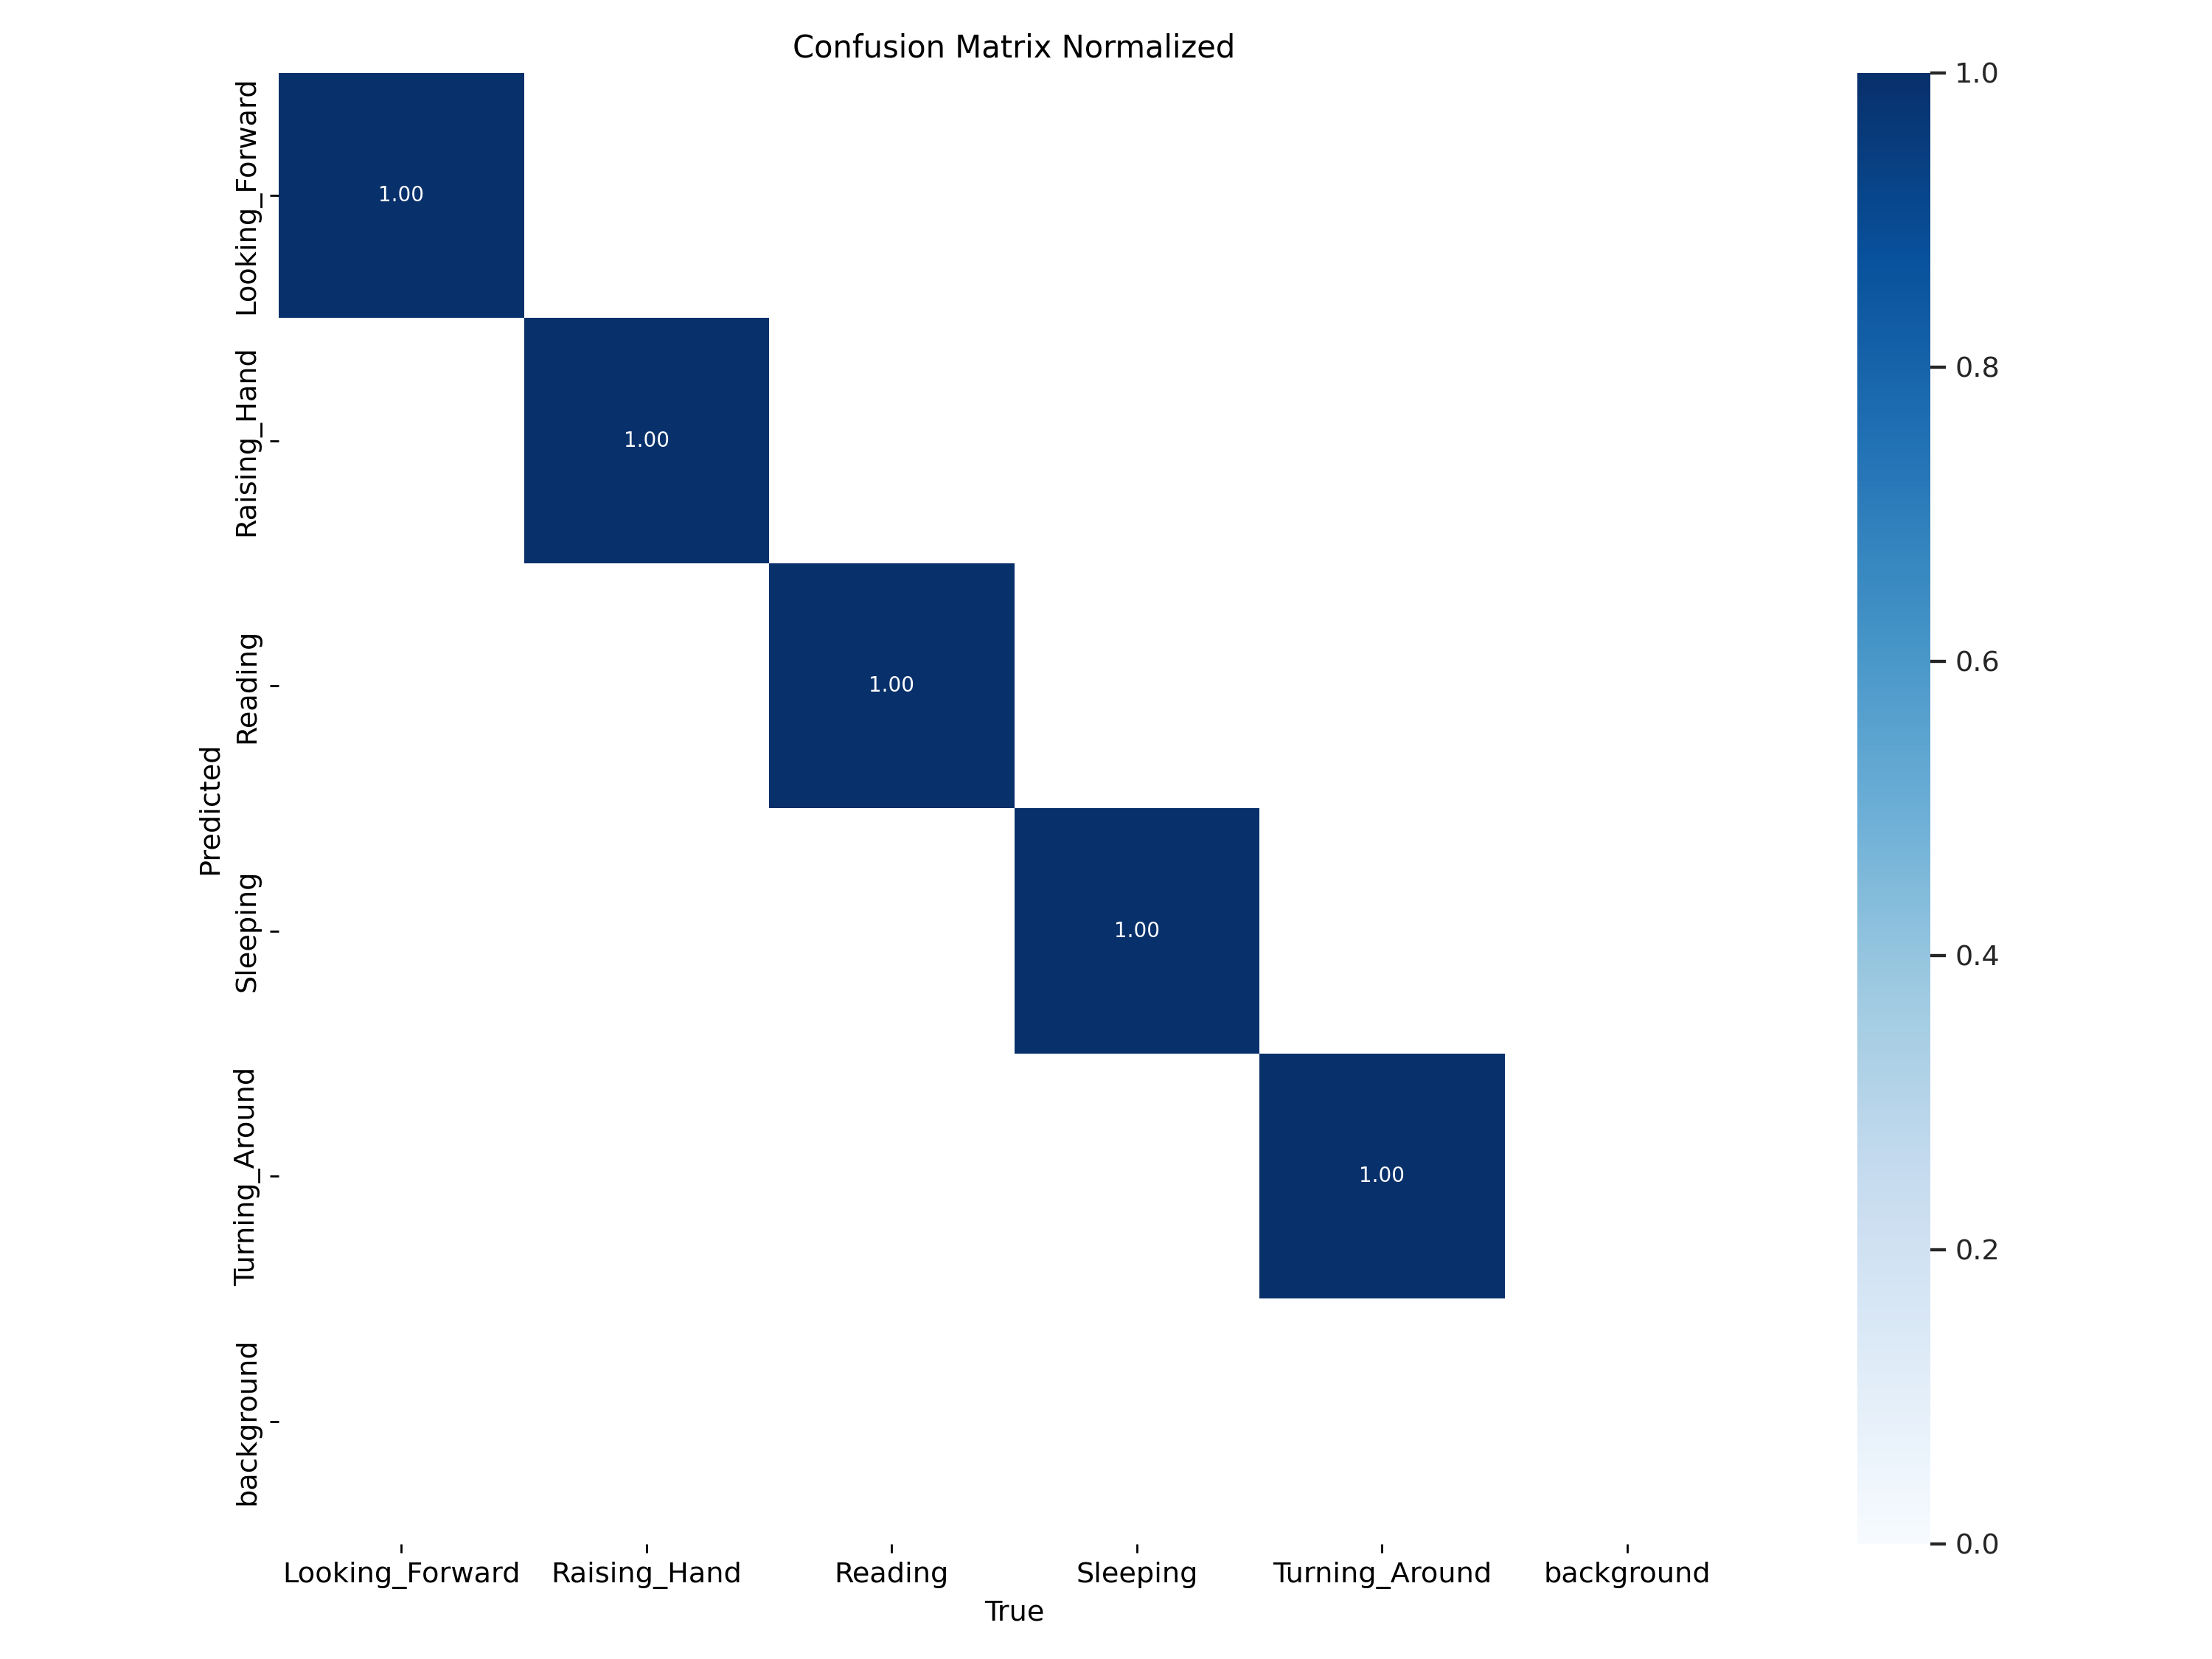

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix_normalized.png', width=600)

/kaggle/working


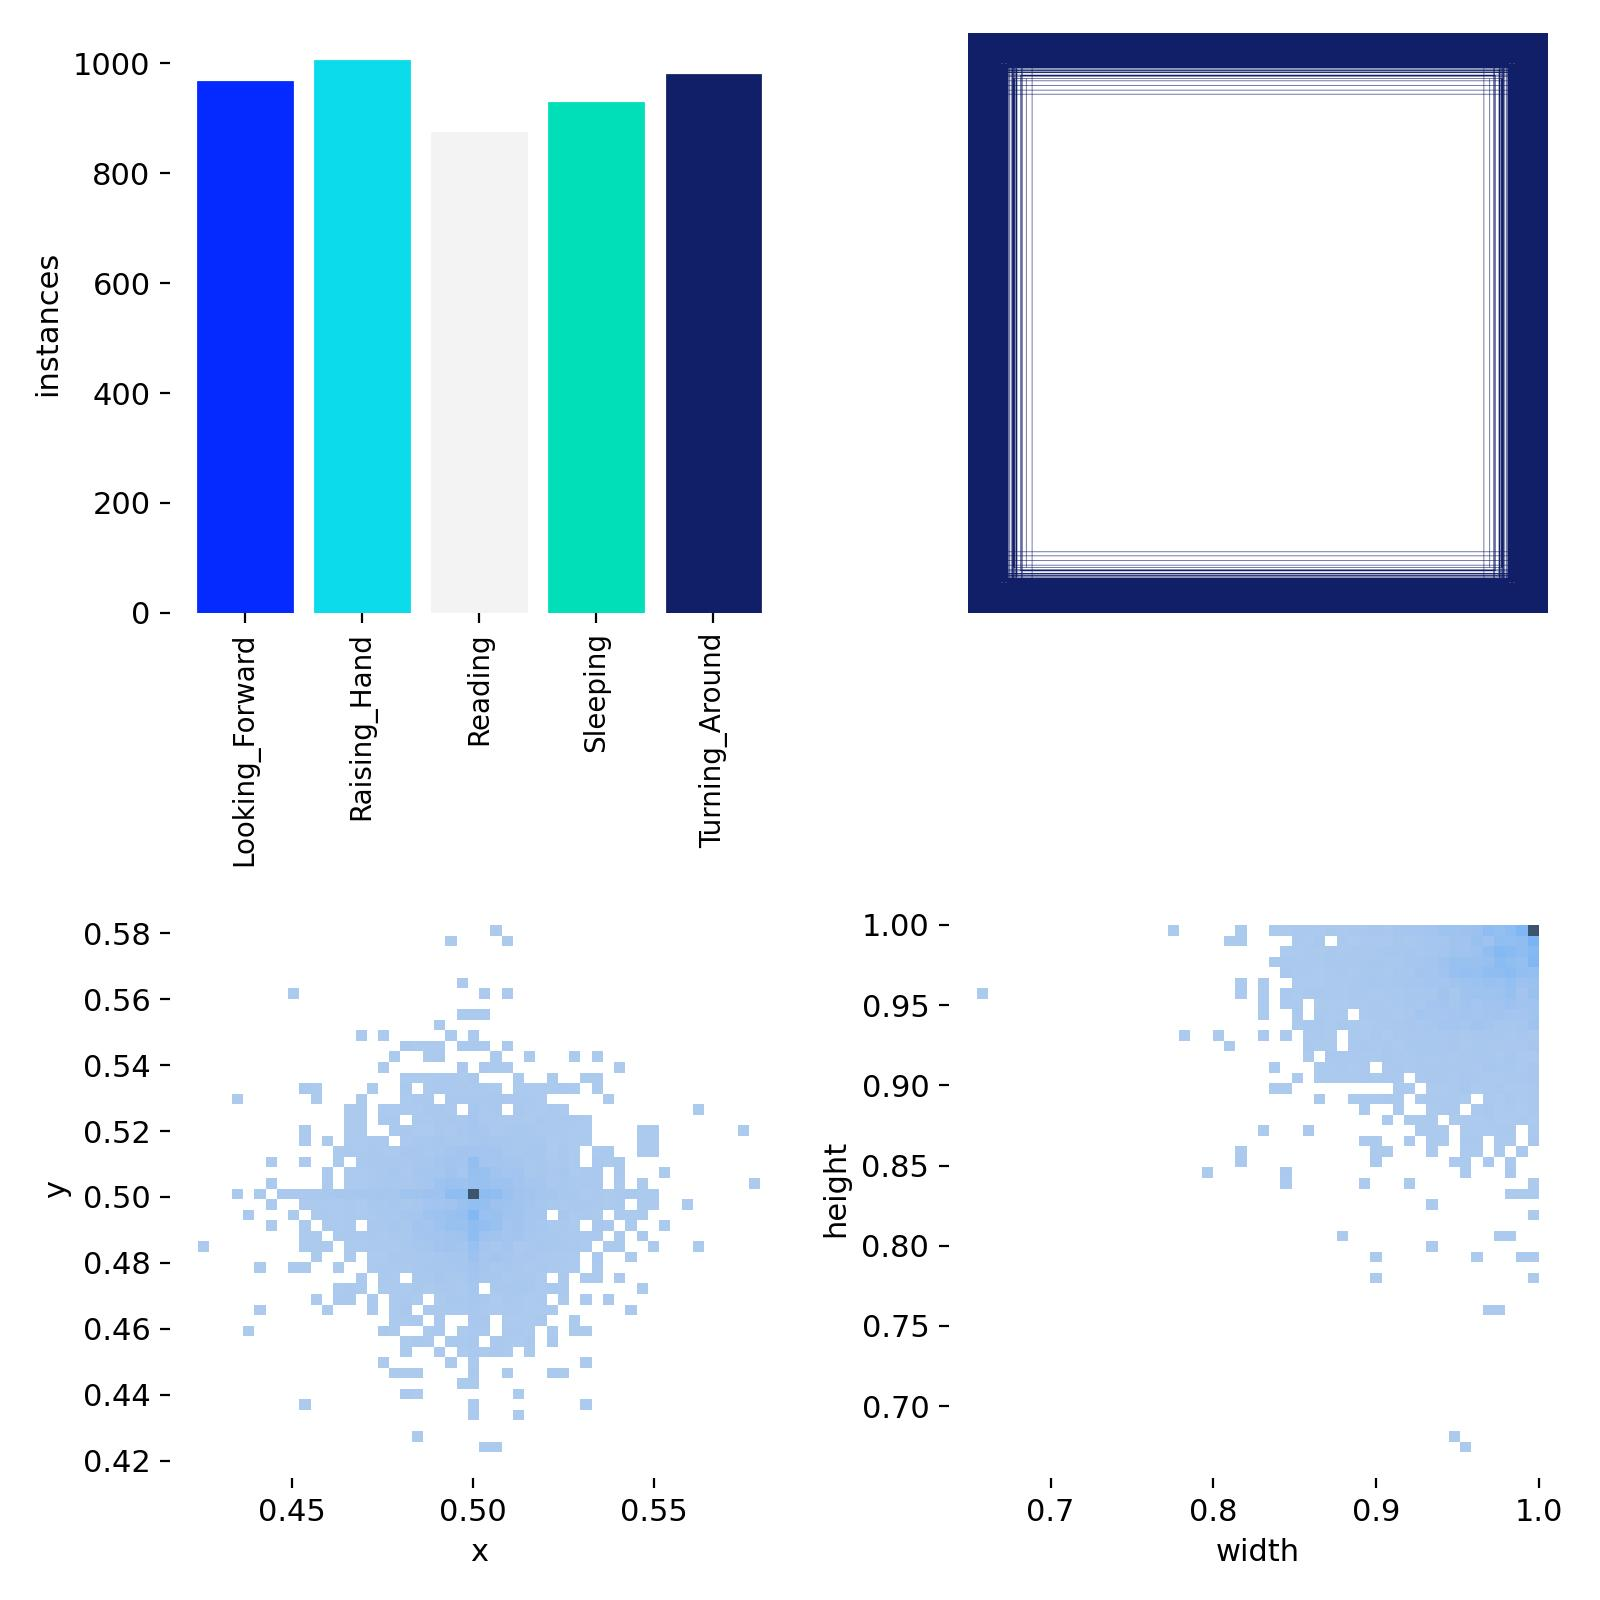

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/labels.jpg', width=600)

/kaggle/working


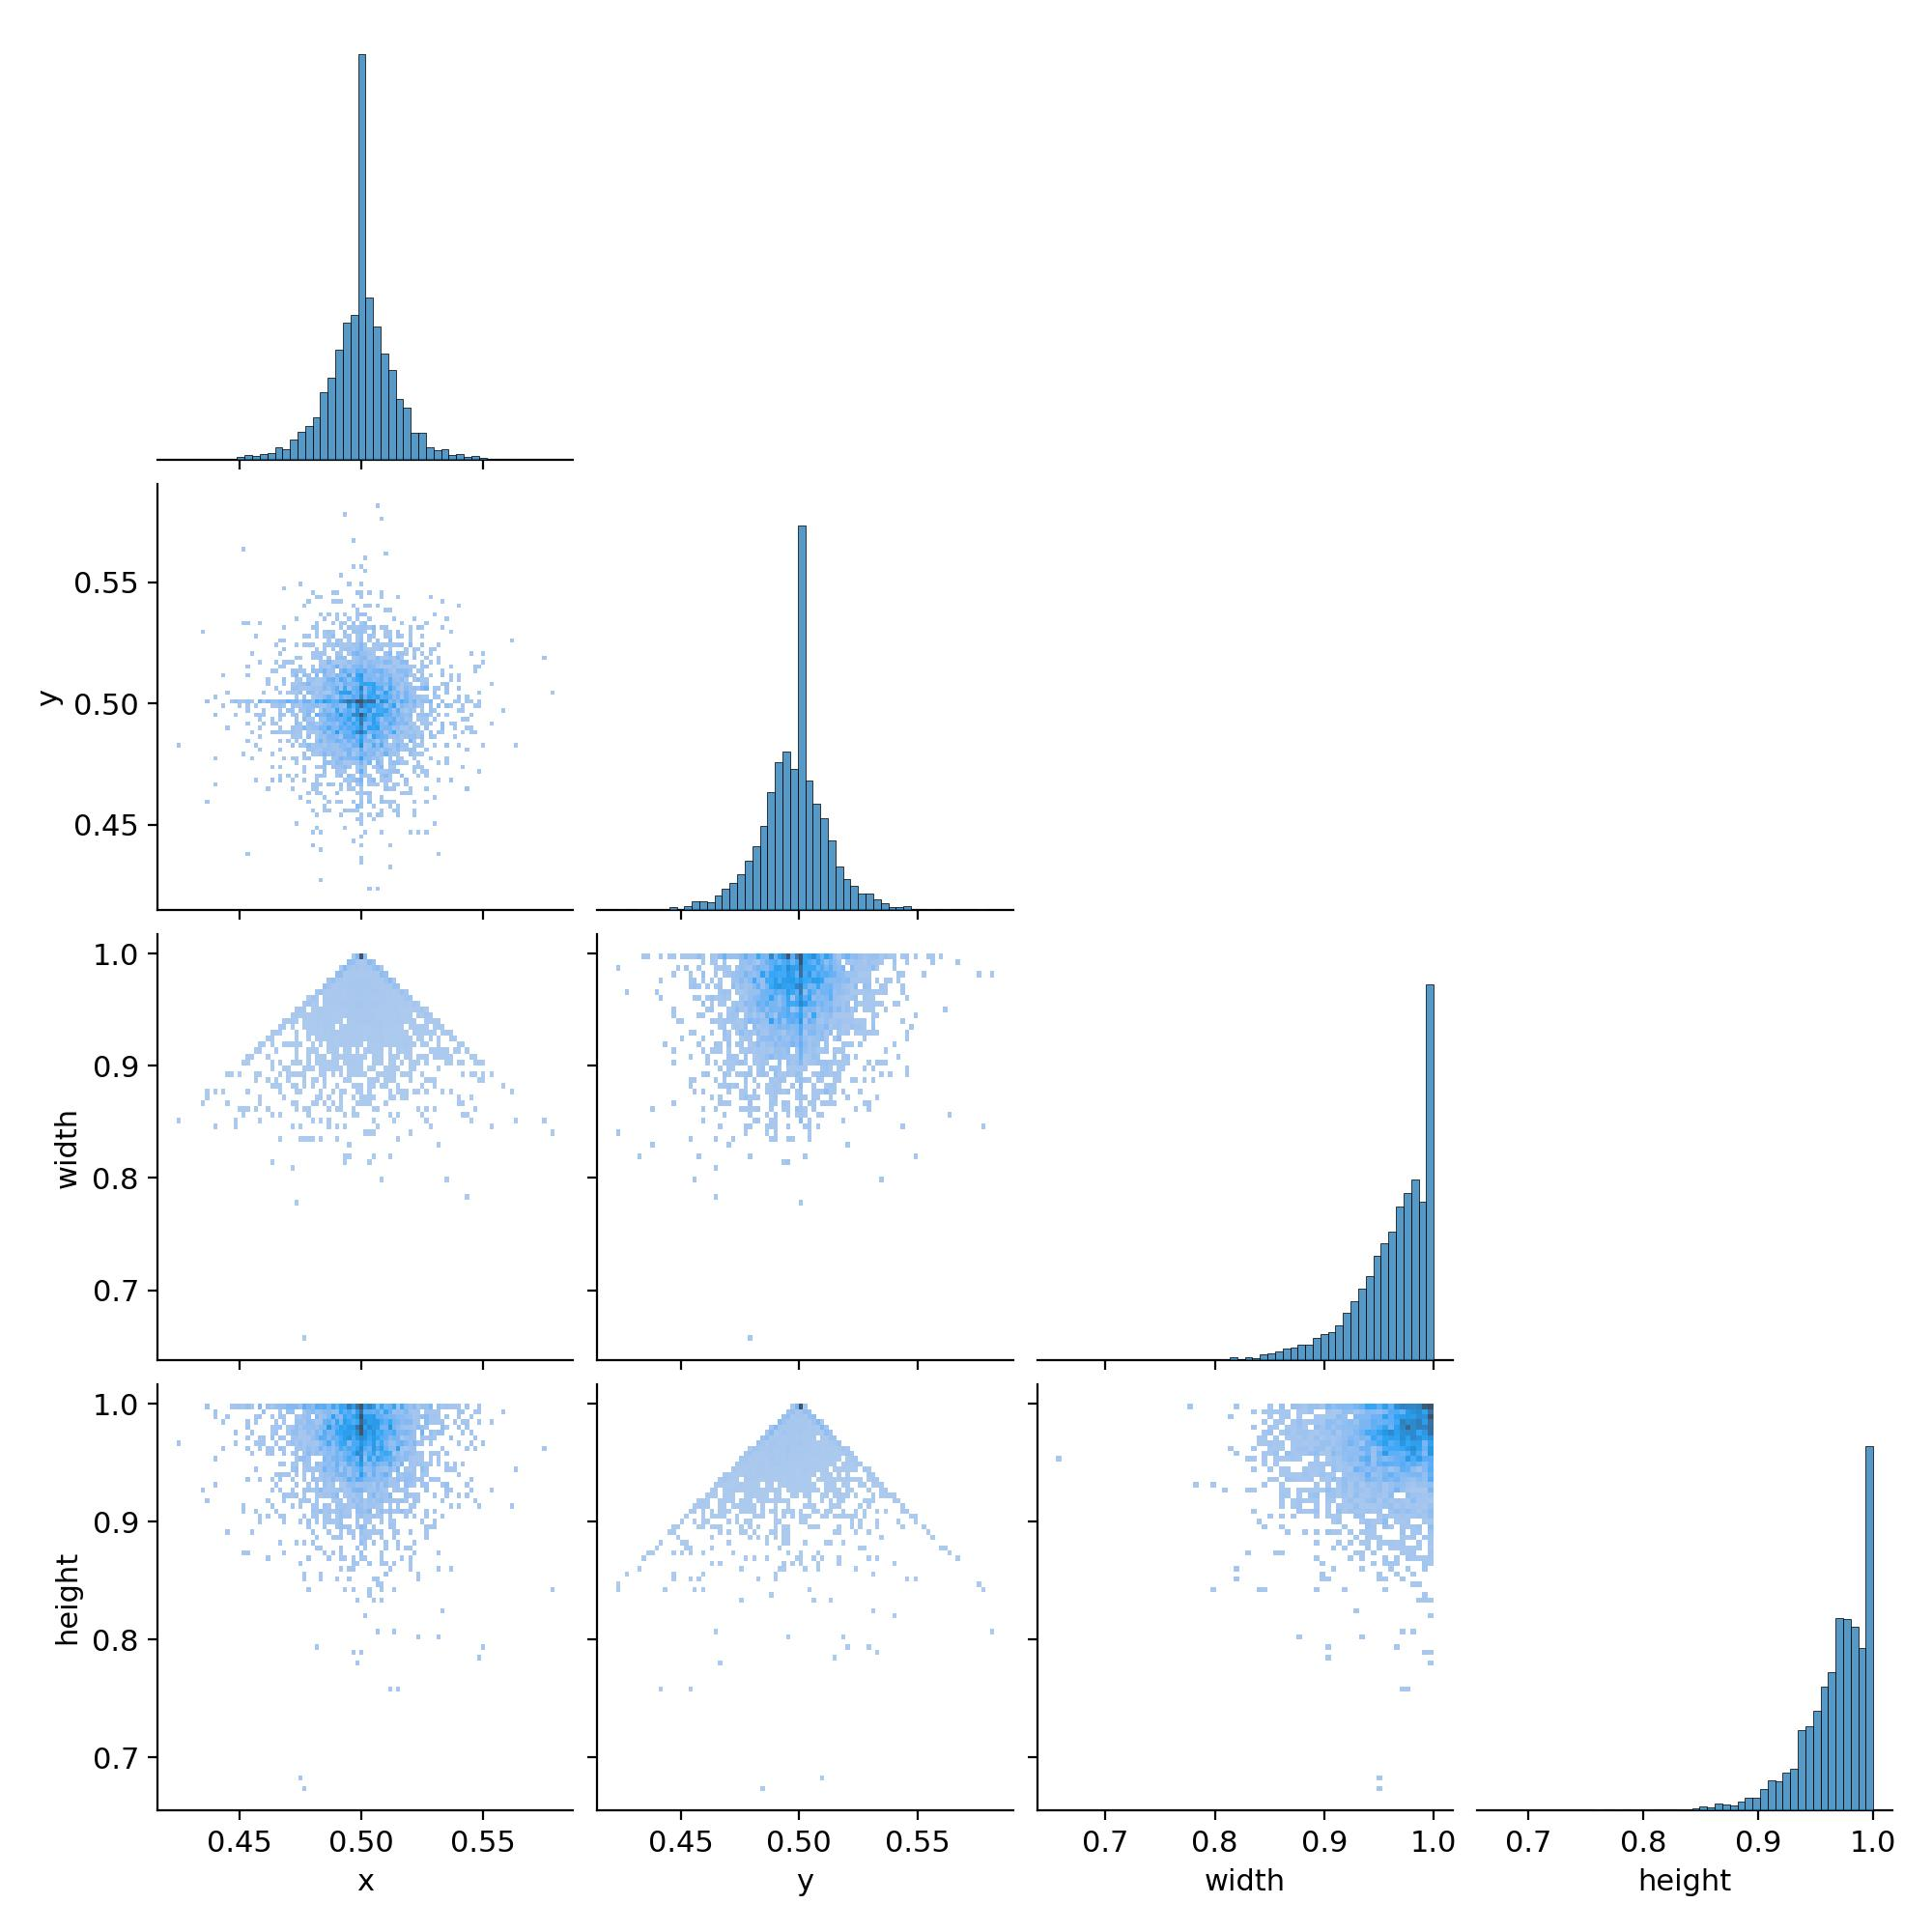

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/labels_correlogram.jpg', width=600)

In [ ]:
import pandas as pd
print(pd.read_csv("/kaggle/working/runs/detect/train2/results.csv"))

                      epoch           train/box_loss           train/cls_loss  \
0                         1                  0.22389                  0.15276   
1                         2                  0.24684                  0.23838   
2                         3                  0.26008                  0.26428   
3                         4                  0.26371                  0.26648   
4                         5                  0.26285                  0.25558   
5                         6                  0.25953                  0.22563   
6                         7                  0.26082                  0.23043   
7                         8                  0.25497                  0.20789   
8                         9                  0.25046                  0.20555   
9                        10                  0.25273                  0.19673   
10                       11                  0.25645                  0.19881   
11                       12 

In [ ]:
from ultralytics import YOLO


best_model = YOLO("/kaggle/working/runs/detect/train2/weights/best.pt")
last_model = YOLO("/kaggle/working/runs/detect/train2/weights/last.pt")

In [ ]:
import os

# Check if best.pt exists
weights_path = "/kaggle/working/runs/detect/train2/weights/best.pt"
print("File exists:", os.path.exists(weights_path))

# List all files in the directory
print("Files in the directory:", os.listdir("/kaggle/working/runs/detect/train2/weights/"))


File exists: True
Files in the directory: ['last.pt', 'best.pt']


In [ ]:
from ultralytics import YOLO

# Use the correct path to best.pt
best_model_path = "/kaggle/working/runs/detect/train2/weights/best.pt"
model = YOLO(best_model_path)


In [ ]:
import os

train_runs_path = "/kaggle/working/runs/detect/"
print("Available training runs:", os.listdir(train_runs_path))


Available training runs: ['train2', 'train', 'predict']


In [ ]:
last_model_path = "/kaggle/working/runs/detect/train2/weights/last.pt"
model = YOLO(last_model_path)


In [ ]:
image_path = "/kaggle/working/datasets/Student-action-recognition-1/test/images/around07_rgb_1_frame30_png_jpg.rf.923f36c4d145167bded81064e7b6c0f3.jpg"

model.predict(source=image_path, save=True, conf=0.25)



image 1/1 /kaggle/working/datasets/Student-action-recognition-1/test/images/around07_rgb_1_frame30_png_jpg.rf.923f36c4d145167bded81064e7b6c0f3.jpg: 800x800 1 Turning_Around, 10.0ms
Speed: 3.8ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 800, 800)
Results saved to runs/detect/predict2


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Looking_Forward', 1: 'Raising_Hand', 2: 'Reading', 3: 'Sleeping', 4: 'Turning_Around'}
 obb: None
 orig_img: array([[[ 77,  88, 116],
         [ 77,  88, 116],
         [ 77,  88, 116],
         ...,
         [165, 166, 162],
         [165, 166, 162],
         [165, 166, 162]],
 
        [[ 77,  88, 116],
         [ 77,  88, 116],
         [ 78,  89, 117],
         ...,
         [165, 166, 162],
         [165, 166, 162],
         [165, 166, 162]],
 
        [[ 76,  87, 115],
         [ 77,  88, 116],
         [ 78,  89, 117],
         ...,
         [165, 166, 162],
         [165, 166, 162],
         [165, 166, 162]],
 
        ...,
 
        [[125, 159, 183],
         [124, 158, 182],
         [124, 158, 182],
         ...,
         [156, 164, 164],
         [156, 164, 164],
         [156, 164, 164]],
 
        [[124, 158, 182],
      

In [ ]:
from ultralytics import YOLO


model = YOLO("/kaggle/working/runs/detect/train2/weights/best.pt")


results = model.predict(source="/kaggle/working/datasets/Student-action-recognition-1/test/images/around06_rgb_1_frame119_png_jpg.rf.e23a1c5aaae1ea4c6415b8a4297355f7.jpg", save=True, conf=0.25)



image 1/1 /kaggle/working/datasets/Student-action-recognition-1/test/images/around06_rgb_1_frame119_png_jpg.rf.e23a1c5aaae1ea4c6415b8a4297355f7.jpg: 800x800 1 Turning_Around, 10.0ms
Speed: 4.2ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 800, 800)
Results saved to runs/detect/predict3


In [ ]:

for result in results:
    print("Predictions:")
    for box in result.boxes:
        class_id = int(box.cls[0])
        confidence = box.conf[0].item()
        print(f"Class ID: {class_id}, Confidence: {confidence:.2f}")


Predictions:
Class ID: 4, Confidence: 0.93


In [ ]:

class_names = model.names


for result in results:
    print("Predictions:")
    for box in result.boxes:
        class_id = int(box.cls[0])
        confidence = box.conf[0].item()
        print(f"Class: {class_names[class_id]}, Confidence: {confidence:.2f}")


Predictions:
Class: Turning_Around, Confidence: 0.93


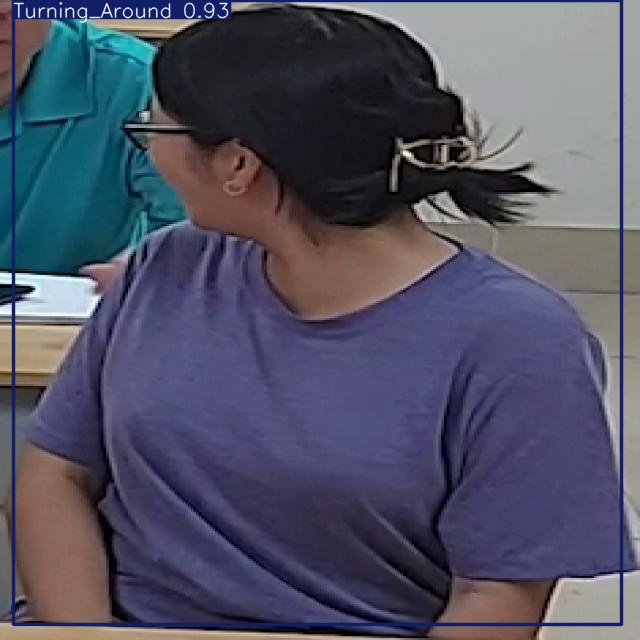

In [ ]:
import glob
from IPython.display import Image, display

base_path = '/kaggle/working/runs/detect/'


subfolders = [os.path.join(base_path, d) for d in os.listdir(base_path)
              if os.path.isdir(os.path.join(base_path, d)) and d.startswith('predict')]


latest_folder = max(subfolders, key=os.path.getmtime)

image_paths = glob.glob(f'{latest_folder}/*.jpg')[:3]


for image_path in image_paths:
    display(Image(filename=image_path, width=600))
    print("\n")

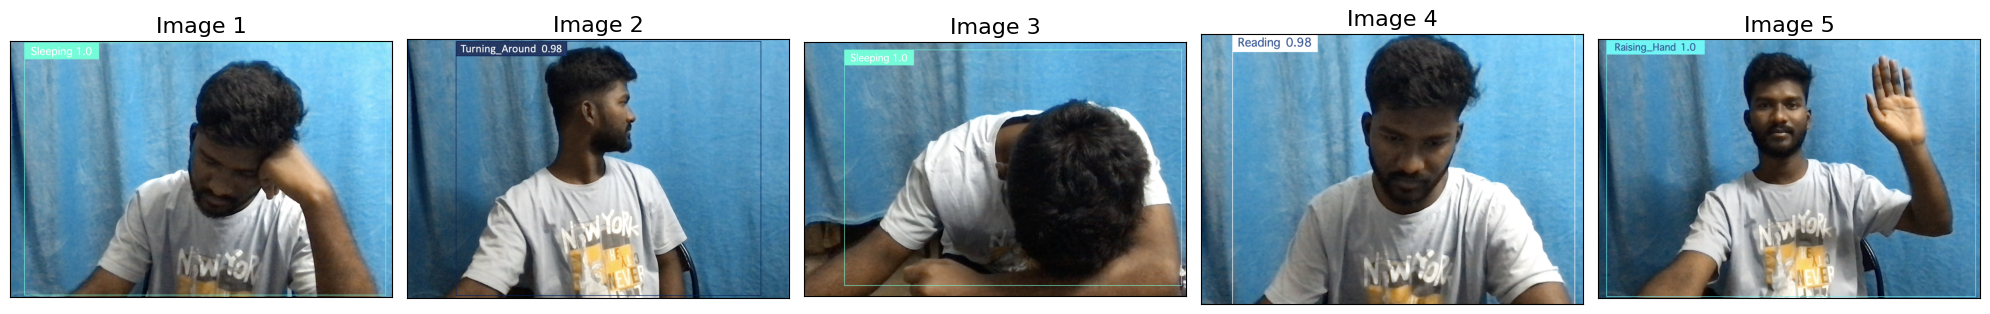

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image


folder_path = "/kaggle/working/runs/detect/predict/vitimages"


image_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".png", ".jpeg"))]


plt.figure(figsize=(20, 10))

for i, img_file in enumerate(image_files[:5]):
    img_path = os.path.join(folder_path, img_file)
    img = Image.open(img_path)


    ax = plt.subplot(1, 5, i + 1)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Image {i+1}", fontsize=16)

plt.tight_layout()
plt.show()
